# Selection of $B_s \rightarrow \psi(2S)\,K_S$ events: A lab exercise

In this notebook you will perform the (most interesting) part of a **real physics data analysis** of the $B_s \rightarrow \psi(2S)\,K_S$ decay:  
The filtering of the tiny fraction of interesting events from the vast amount of total data that is recorded in the LHCb experiment at CERN.  
You will be learning about classification tasks in particle physics, utilizing machine learning algorithms and expert systems to squeeze out the best performance.  
But let's not panic, we go through it step by step!

We will work on three samples:
- The real data set.
- Monte-Carlo simulation of the signal decay $B_s \rightarrow \psi(2S)\,K_S$.
- Monte-Carlo simulation of the (kinematically) similar decay $B_d \rightarrow \psi(2S)\,K_S$.


Let's first define the paths to the samples.

In [1]:
retrain = False # Set this to True if the data or feature selection is changed for one run, and then set it back to False!!! 
                # Saves hours if used correctly!!!

In [2]:
# python plotting library
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#actual data
path_to_data = "/data/Bs2psi2SKS/data.root"
#signal simulation
path_to_sim = "/data/Bs2psi2SKS/signal_sim.root"
#control channel simulation
path_to_control_sim = "/data/Bd2psi2SKS/control_sim.root"

The nomenclature here is:
 - data = the actual data coming from LHCb
 - signal sim = monte-carlo simulation of our signal decay $B_s \rightarrow \psi(2S)\,K_S$
 - control sim = monte-carlo simulation of the similar decay $B_d \rightarrow \psi(2S)\,K_S$

### Reading the data from a "ROOT" file

Everything at CERN works with [ROOT](https://root.cern.ch), also the output of our distributed data processing chain.  
ROOT is incredibly powerful, but also not too easy to use..  
Let's not try to make it work, but rather use [uproot](https://github.com/scikit-hep/uproot) to put our data into [pandas dataframes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

In [4]:
def get_data(path, chunk_size=None, treename = 'Tree', branches = None):
    import numpy as np
    import uproot
    if not chunk_size:
        return uproot.open(path)[treename].pandas.df(branches=branches, flatten=False).replace([np.inf, -np.inf], np.nan).dropna()
    for data in uproot.open(path)[treename].pandas.iterate(entrysteps = chunk_size, flatten=False, branches=branches):
        return data.replace([np.inf, -np.inf], np.nan).dropna()

## 1. Data Exploration
Let's have a look at our simulation first.

**Ex 1.1: Get a dataframe of the signal simulation and plot the invariant $B_s$ mass.**  
<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">The name is B_FitDaughtersConst_M_flat</a></h4>

In [5]:
sim_signal = get_data(path_to_sim, branches=["B_FitDaughtersConst_M_flat"])
sim_signal.head()

,B_FitDaughtersConst_M_flat
entry,
0,5365.507812
1,5364.294434
2,5368.935547
3,5367.214844
4,5365.221680


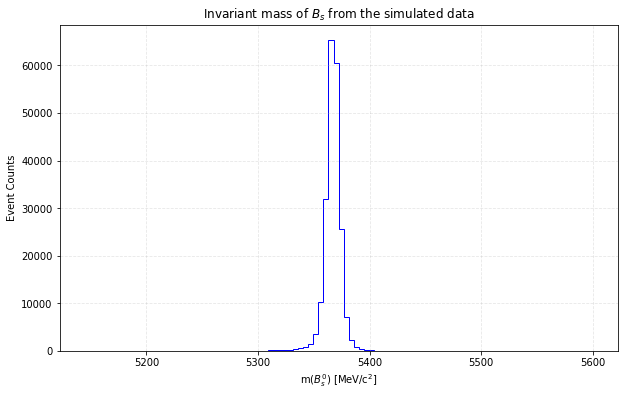

In [6]:
plt.figure(figsize=(10,6))
plt.hist(sim_signal["B_FitDaughtersConst_M_flat"], bins=100, histtype="step", color="blue", alpha=1)
plt.xlabel(r"m($B_{s}^0$) [MeV/c$^2$]")
plt.ylabel("Event Counts")
plt.title(r"Invariant mass of $B_{s}$ from the simulated data")
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("invmasssim.png", dpi= 120)
plt.show()

In [7]:
data = sim_signal["B_FitDaughtersConst_M_flat"]
counts, bin_edges = np.histogram(data, bins=100)
max_bin_index = np.argmax(counts)
peak = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1])/2
print(f"We have a peak at a mass of {peak:.2f} MeV.")

We have a peak at a mass of 5365.37 MeV.


Your plot should show a peaking structure near the nominal $B_s$ mass: $m(B_s) = 5366.88\,\text{MeV}$.


Let's do the same for our data:

**Ex 1.2: Plot the invariant $B_s$ mass of the data.**

In [8]:
data_signal = get_data(path_to_data, branches=["B_FitDaughtersConst_M_flat"])
data_signal.head()

,B_FitDaughtersConst_M_flat
entry,
0,5758.790039
1,5717.746094
2,5393.692871
3,6013.325195
4,5449.129883


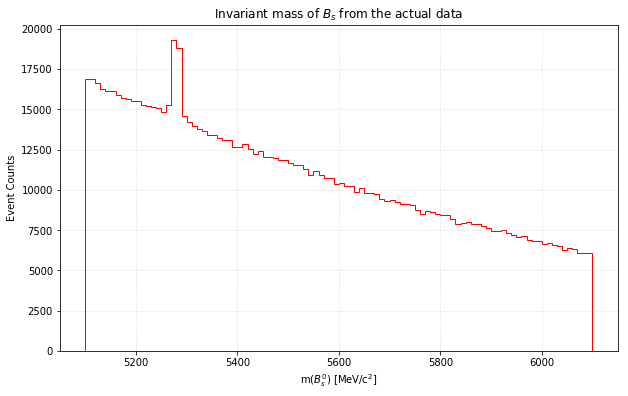

In [9]:
plt.figure(figsize=(10,6))
plt.hist(data_signal["B_FitDaughtersConst_M_flat"], bins=100, histtype="step", color="red", alpha=1)
plt.xlabel(r"m($B_{s}^0$) [MeV/c$^2$]")
plt.ylabel("Event Counts")
plt.title(r"Invariant mass of $B_{s}$ from the actual data")
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("invmassdata", dpi=120)
plt.show()

While the LHC is running, millions of collisions happen every second at LHCb, resulting in 40Tb/s of data. The data you see here contains events from the entire Run 2 of the LHC (2015 - 2018), but obviously already **heavily preselected** by the trigger and other centralized selections.

Still, the amount of (for our purposes) uninteresting events is still overwhelming, and this is what you see in the mass distribution. The $B_s \rightarrow \psi(2S)\,K_S$ signal events are hiding somewhere in this mess. And besides the peaking structure (which does not correspond to the $B_s$), the data sample is dominated by **combinatorial background**.

Our goal is to find the needles in the haystack here, so lets get on with it!

Here is an **outline** of the tasks ahead:
 2. Define a **signal window** and a **background sample**
 3. **Select features** that discriminate signal and background well
 4. Build an algorithm that tries to **predict how signal-like** an event is, using these features
 5. **Optimize a threshold** to split the data into signal and background
 6. Apply the classification to the signal window in our data and **fit** the resulting distribution to
    quantify how clearly we can make out $B_s \rightarrow \psi(2S)\,K_S$

## 2.  Define signal and background training samples

We will train our classifier on signal and background samples.

### 2.1 Signal window and background sample
**Ex 2.1:**  
**Define a window in which we expect signal to appear: The shortest interval that contains 99\% of the signal-MC mass distribution and visualize your result**

<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z"> Compute all intervalls containing 99% and take the shortest.</a></h4>

In [10]:
# First let's take all the mass values as a numpy array from the simulated data and sort them to increasing order
sim_mass = np.sort(sim_signal["B_FitDaughtersConst_M_flat"].values)

# Get the total number of events and then calculate how many of them correspond to 99% of mass distribution
number_events = len(sim_mass)
number_99 = int(0.99*number_events)  

# Compute the shortest interval
min_window = float('inf')      # since we don't know the interval length, anything will be shorter than infinity
best_low, best_high = 0, 0     # these will hold the bounds of the shortest interval found


# loop over the window containing 99% of the simulated data
for i in range(number_events - number_99):    
    current_window = sim_mass[i+number_99]-sim_mass[i]
    if current_window < min_window:
        min_window = current_window
        best_low, best_high = sim_mass[i], sim_mass[i+number_99]   # update the bounds

print(f"Shortest 99% window: [{best_low:.2f}, {best_high:.2f}] MeV")
print(f"Window width: {min_window:.2f} MeV")

Shortest 99% window: [5333.42, 5394.60] MeV
Window width: 61.17 MeV


Now that we have defined a signal window, lets see where it is in the data mass distribution.  

**Ex 2.2: Plot the data mass distribution with the signal window**

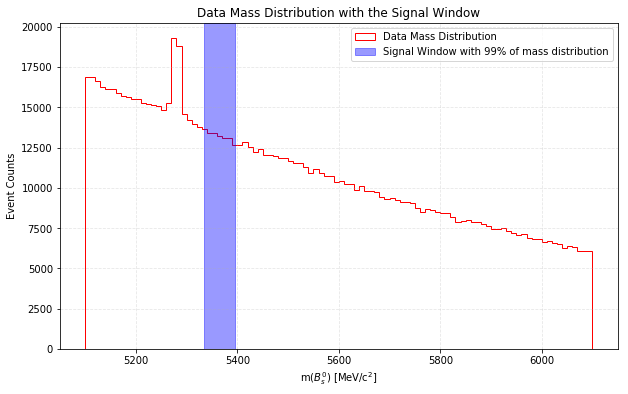

In [11]:
plt.figure(figsize=(10,6))
plt.hist(data_signal["B_FitDaughtersConst_M_flat"], bins=100, histtype="step", color="red", alpha=1, label="Data Mass Distribution")
plt.axvspan(best_low, best_high, color="blue", alpha=0.4, label="Signal Window with 99% of mass distribution")
plt.legend(loc="best")
plt.title("Data Mass Distribution with the Signal Window")
plt.xlabel(r"m($B_{s}^0$) [MeV/c$^2$]")
plt.ylabel("Event Counts")
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("signalwindow.png", dpi=120)
plt.show()

To train the classifier, we should never use the signal window because it could bias the classifier. Instead, we need to define suitable signal and background training samples to work on.  
Our signal sample will be the signal simulation, and as background we want to choose the **upper sideband (USB)** of the $B_s$ peak (yet invisible) in the data. The USB of the $B_s$ peak contains the events with reconstructed $B_s$ masses larger than the nominal $B_s$ mass. It contains only combinatorial background and is therefore perfect for the job, since this is what we want to get rid of.  

**Ex 2.3: Select the background sample**

In [12]:
# the USB should contain events with masses larger than the signal window
bkg_sample = data_signal[data_signal["B_FitDaughtersConst_M_flat"]> best_high]
bkg_sample.head()

,B_FitDaughtersConst_M_flat
entry,
0,5758.790039
1,5717.746094
3,6013.325195
4,5449.129883
5,5471.262695


In [13]:
# look at the size of the background sample to compare with the actual data
print(f"The size of the background sample is {bkg_sample.size}, while the size of the actual data is {data_signal.size}.")

The size of the background sample is 644218, while the size of the actual data is 1092793.


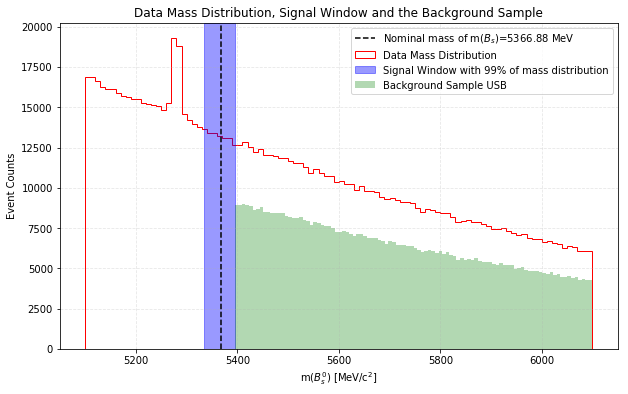

In [14]:
# plot to see if it is where it should be
plt.figure(figsize=(10,6))
plt.hist(data_signal["B_FitDaughtersConst_M_flat"], bins=100, histtype="step", color="red", alpha=1, label="Data Mass Distribution")
plt.axvspan(best_low, best_high, color="blue", alpha=0.4, label="Signal Window with 99% of mass distribution")
plt.hist(bkg_sample["B_FitDaughtersConst_M_flat"], bins=100, histtype="stepfilled", color="g", alpha=0.3, label="Background Sample USB")
plt.axvline(5366.88, color="black", linestyle="--", label=r"Nominal mass of m($B_{s}$)=5366.88 MeV")
plt.title("Data Mass Distribution, Signal Window and the Background Sample")
plt.xlabel(r"m($B_{s}^0$) [MeV/c$^2$]")
plt.ylabel("Event Counts")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc="best")
plt.savefig("bkgsample.png", dpi=120)
plt.show()

### 2.2 Signal training sample
Our simulation algorithms are far from perfect, mainly due to imperfect theoretical physics models and our imperfect modelling of the detector to simulate responses. For example, some aspects of the decay kinematics are often imperfect in simulation and are corrected for using such weights, stored in the variable `kinematic_weights`. You should use these weights for everything from now on.

But other properties may be mis-modelled by the simulation as well. This means that even if you find the most discriminating variables now (using the`kinematic_weights`) and train a classifier with them, your classifier would only be able to classify simulation and data - instead of signal and background.

Therefore, we need to evaluate how similar simulation and data are in each variable without having $B_s$ data to compare the simulation with. And here we take advantage of the decay $B^0\to\psi(2S)K_S$. The $B^0$ decay is similar to the $B_s$ decay, especially in the kinematic variables which will be very important in the removal of combinatorial background. Additionally, the $B^0$ decay is very abundant, we can already see it by eye in the data set.

Fortunately, the sWeights `sWeights_sig` giving us pure $B^0$ events from the data sample have already been computed.
**Caution:** sWeighted data distributions are only a reliable representation of the true distribution if the variable you look at is uncorrelated to the invariant $B$ mass.

**Ex. 2.4: Plot the reconstructed invariant mass of the $B$ meson in the data set with and without sWeights**

In [15]:
# let's get the weights column as well
data_signal=get_data(path_to_data, branches=["B_FitDaughtersConst_M_flat", "sweights_sig"])
data_signal.head()

,B_FitDaughtersConst_M_flat,sweights_sig
entry,,
0,5758.790039,-0.030437
1,5717.746094,-0.030437
2,5393.692871,-0.030420
3,6013.325195,-0.030437
4,5449.129883,-0.030435


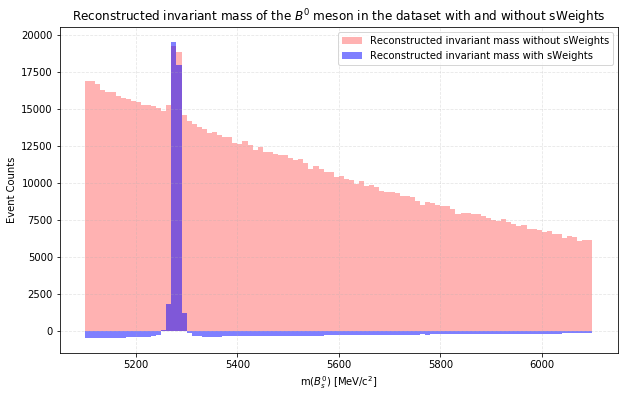

In [16]:
plt.figure(figsize=(10,6))
plt.hist(data_signal["B_FitDaughtersConst_M_flat"], bins=100, color="red", alpha=0.3, label="Reconstructed invariant mass without sWeights")
plt.hist(data_signal["B_FitDaughtersConst_M_flat"], weights=data_signal["sweights_sig"], bins=100, color="blue", alpha=0.5, label="Reconstructed invariant mass with sWeights")
plt.title("Reconstructed invariant mass of the $B^{0}$ meson in the dataset with and without sWeights")
plt.xlabel(r"m($B_{s}^0$) [MeV/c$^2$]")
plt.ylabel("Event Counts")
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("recinvmass.png", dpi=120)
plt.show()

**Ex. 2.5: Compare the $B^0$ events in data with the $B^0$ simulation for each variable by eye**

<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z"> Don't forget the weights in both samples.</a></h4>

In [17]:
b_zero = get_data(path_to_control_sim)
b_zero.head()

,B_LOKI_ENERGY,B_LOKI_ETA,B_LOKI_PHI,B_Vtx_Chi2NDOF,B_MINIP,B_MINIPCHI2,B_MINIPNEXTBEST,B_MINIPCHI2NEXTBEST,B_ENDVERTEX_X,B_ENDVERTEX_Y,...,L0MuonDecision,L0DiMuonDecision,L0HadronDecision,L0ElectronDecision,L0PhotonDecision,L0nSelections,MaxRoutingBits,year,rndm_Number,kinematic_weights
entry,,,,,,,,,,,,,,,,,,,,,
0,118001.081928,2.979622,-2.210294,1.260934,0.011516,1.132497,1.788605,5066.406557,0.666560,-0.101048,...,1.0,1.0,1.0,0.0,0.0,3.0,23.0,2015.0,7.878464e+08,0.917764
1,185515.310427,4.046577,2.779411,0.266241,0.006984,0.206641,-1.000000,-1.000000,-0.343695,0.517129,...,1.0,1.0,1.0,0.0,0.0,3.0,28.0,2015.0,2.563452e+09,0.340154
2,117101.124777,3.488257,1.436641,1.643529,0.056144,11.729631,-1.000000,-1.000000,1.019863,1.327901,...,1.0,1.0,1.0,0.0,0.0,3.0,29.0,2015.0,9.019324e+09,0.365576
3,123780.879015,3.490271,0.346467,1.269007,0.010110,0.322746,0.802085,1429.634838,1.799278,0.433519,...,1.0,1.0,1.0,0.0,0.0,3.0,26.0,2015.0,4.537253e+09,1.140994
4,60044.598593,2.846307,2.256952,0.217788,0.027076,4.309093,-1.000000,-1.000000,0.167517,0.937212,...,1.0,0.0,0.0,0.0,0.0,1.0,25.0,2015.0,7.395928e+09,0.382043


In [18]:
data_signal=get_data(path_to_data)
data_signal.head()

,B_LOKI_ENERGY,B_LOKI_ETA,B_LOKI_PHI,B_Vtx_Chi2NDOF,B_MINIP,B_MINIPCHI2,B_MINIPNEXTBEST,B_MINIPCHI2NEXTBEST,B_ENDVERTEX_X,B_ENDVERTEX_Y,...,L0DiMuonDecision,L0HadronDecision,L0ElectronDecision,L0PhotonDecision,L0nSelections,MaxRoutingBits,year,rndm_Number,sweights_sig,sweights_bkg
entry,,,,,,,,,,,,,,,,,,,,,
0,46003.363218,3.558632,-0.255142,3.476284,0.114946,85.326747,2.178289,6794.959632,0.704985,0.045756,...,0.0,1.0,0.0,0.0,2.0,14.0,2015.0,7.878464e+08,-0.030437,1.030437
1,72295.821470,3.690059,2.306503,2.432099,0.111342,61.723376,-1.000000,-1.000000,0.851218,-0.053362,...,0.0,1.0,0.0,0.0,2.0,19.0,2015.0,2.563452e+09,-0.030437,1.030437
2,77710.825923,4.396537,1.180011,1.895903,0.222907,45.441625,0.264474,116.323312,0.751719,0.400648,...,1.0,0.0,0.0,0.0,1.0,13.0,2015.0,9.019324e+09,-0.030420,1.030420
3,46283.563205,3.637305,2.127340,4.327955,0.255885,192.240286,0.528807,700.444821,0.552210,0.301053,...,1.0,0.0,0.0,0.0,1.0,12.0,2015.0,4.537253e+09,-0.030437,1.030437
4,79617.779444,4.732319,-1.912943,6.144928,0.170328,94.857155,0.827224,1631.891532,0.949696,-0.085161,...,0.0,0.0,0.0,0.0,1.0,14.0,2015.0,7.395928e+09,-0.030435,1.030435


In [19]:
variables = [
    'B_LOKI_ENERGY', 'B_LOKI_ETA', 'B_LOKI_PHI', 'B_Vtx_Chi2NDOF', 
    'B_MINIP', 'B_MINIPCHI2', 'B_MINIPNEXTBEST', 'B_MINIPCHI2NEXTBEST',
    'B_ENDVERTEX_CHI2', 'B_OWNPV_CHI2', 'B_IP_OWNPV', 'B_IPCHI2_OWNPV',
    'B_FD_OWNPV', 'B_FDCHI2_OWNPV', 'B_DIRA_OWNPV', 'B_P', 'B_PT', 'B_TAU',
    'B_LOKI_DOCA', 'B_FitDaughtersConst_KS0_decayLength_flat', 
    'B_FitJpsiConst_KS0_ctau_flat', 'B_FitPVConst_decayLength_flat',
    'psi_2S_MINIP', 'psi_2S_MINIPCHI2', 'psi_2S_OWNPV_CHI2', 'psi_2S_IP_OWNPV',
    'psi_2S_IPCHI2_OWNPV', 'psi_2S_FD_OWNPV', 'psi_2S_FDCHI2_OWNPV',
    'psi_2S_DIRA_OWNPV', 'muplus_MINIP', 'muminus_MINIP', 'KS0_Vtx_Chi2NDOF',
    'KS0_MINIP'
]

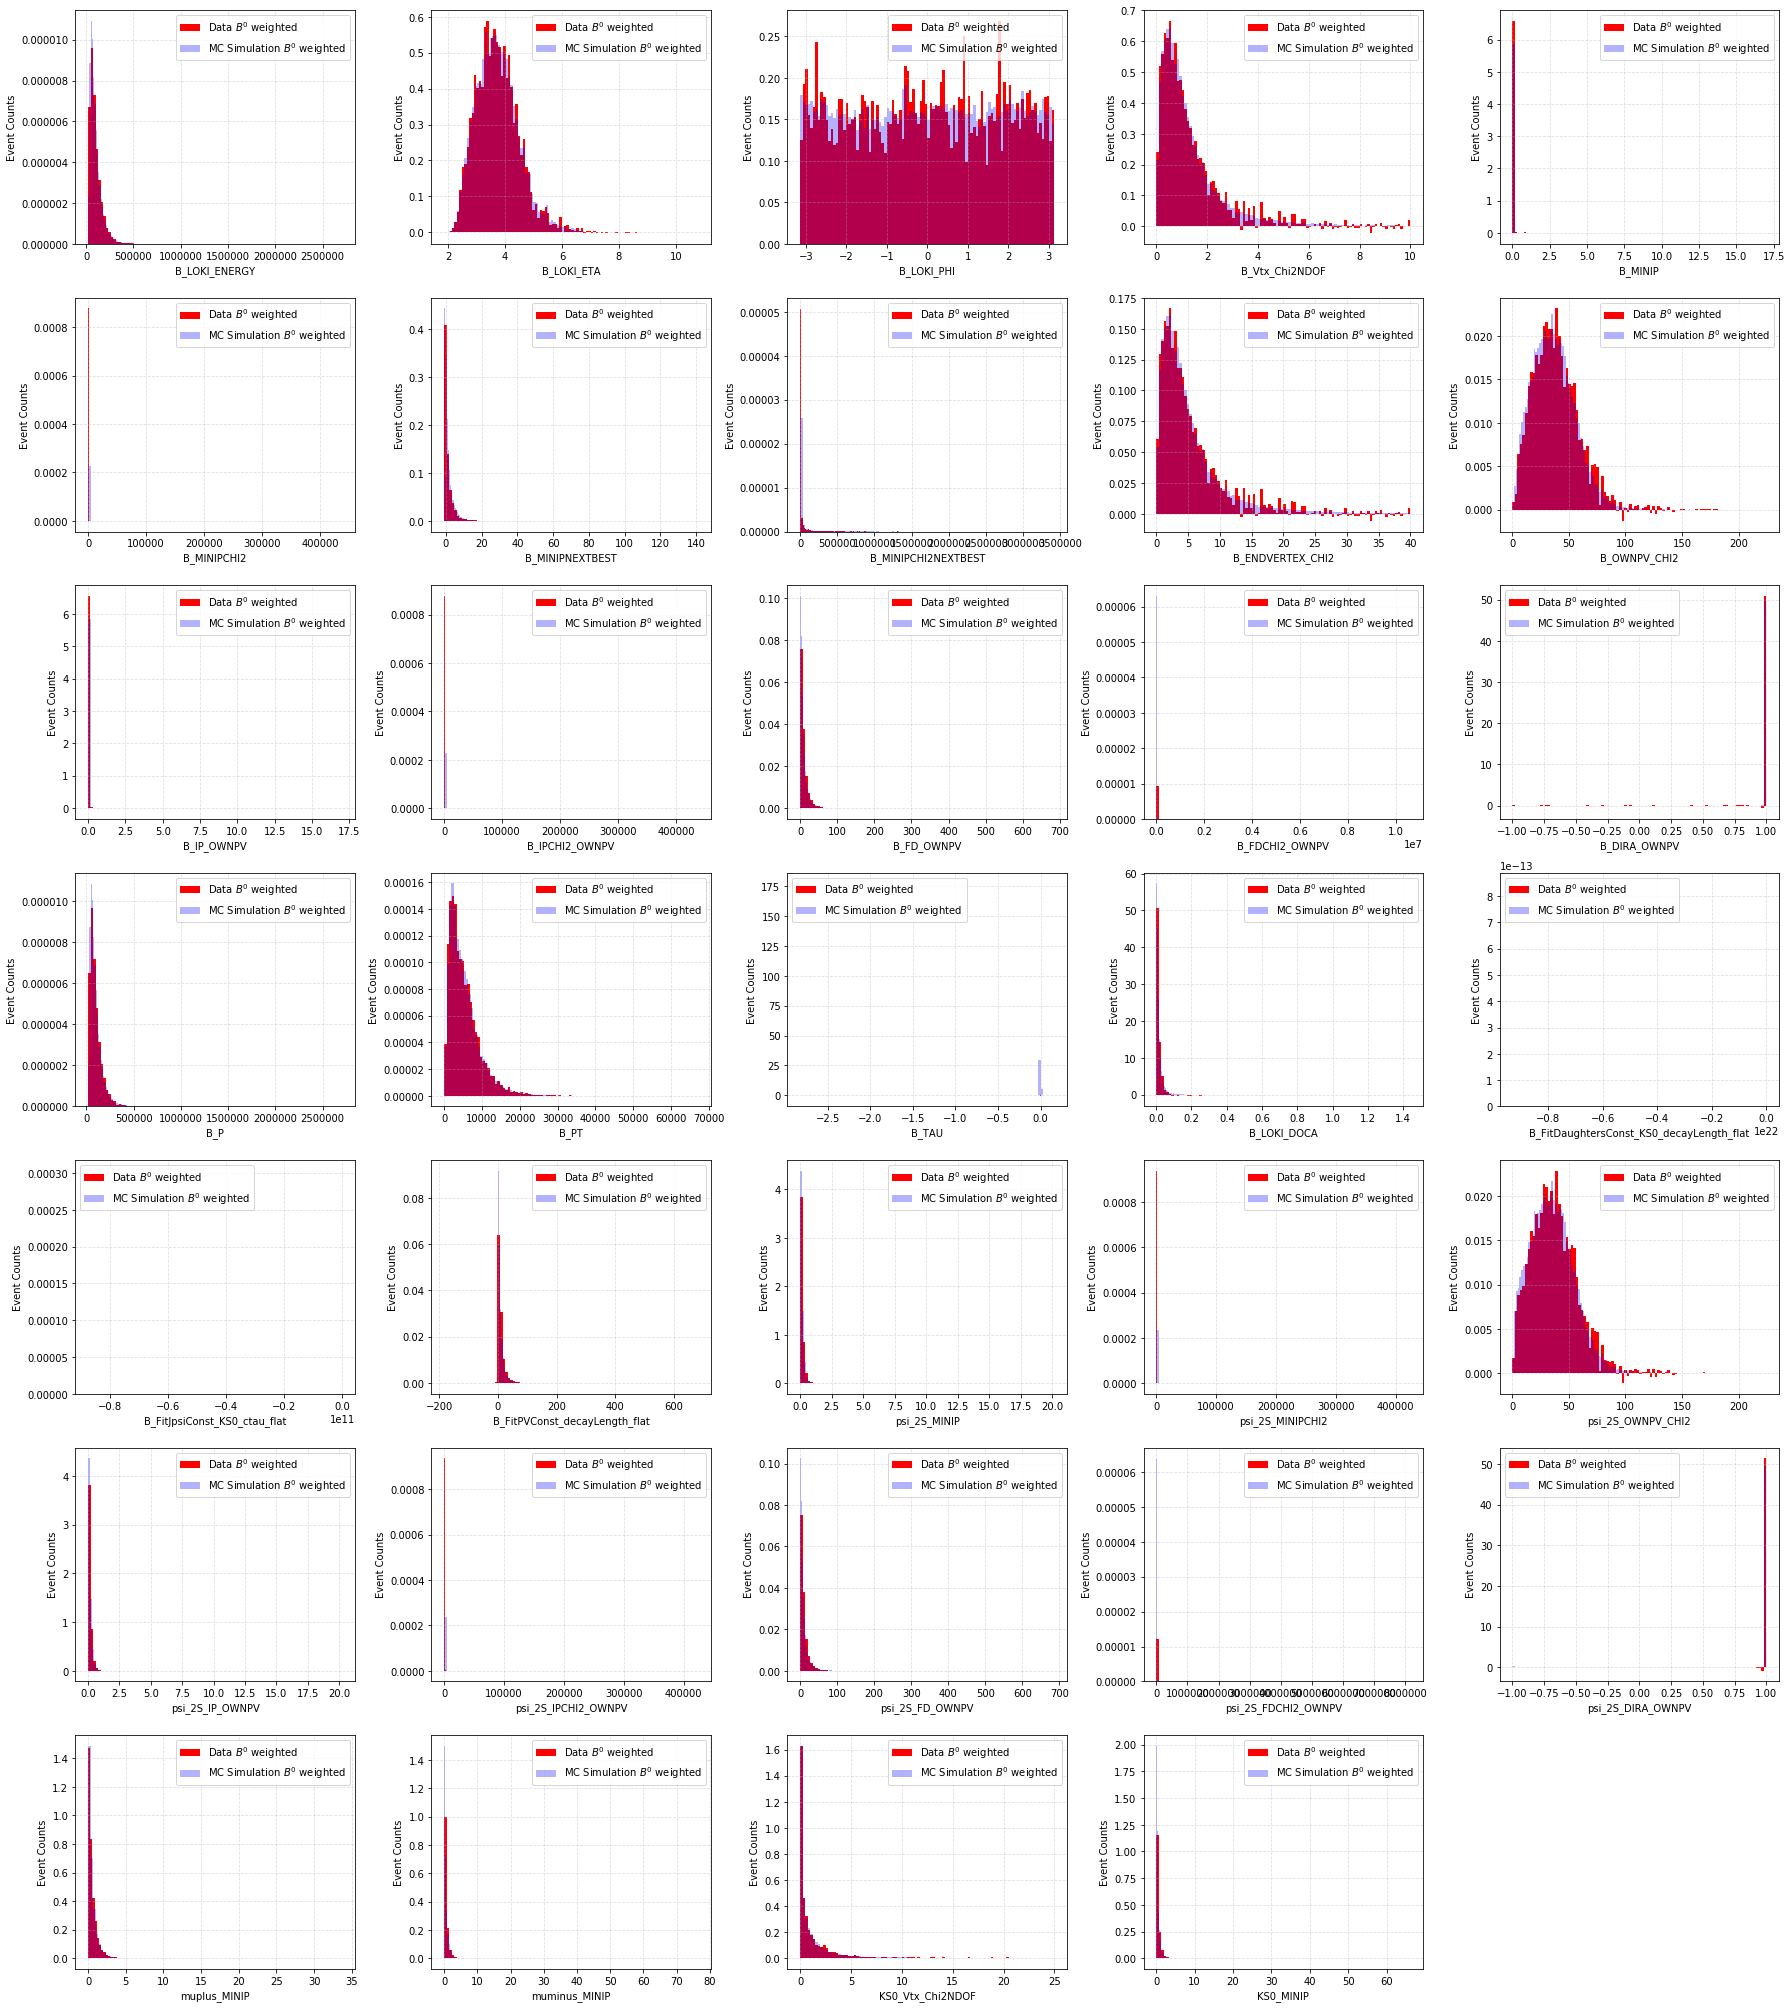

In [20]:
import pandas as pd

n_vars = len(variables)
n_cols = 5
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  

for i, var in enumerate(variables):
    ax = axes[i]
    
    ax.hist(
        data_signal[var], 
        weights=data_signal["sweights_sig"],
        bins=100,
        color="red",
        alpha=1,
        label="Data $B^0$ weighted",
        density=True
    )

    ax.hist(
        b_zero[var], 
        weights=b_zero["kinematic_weights"],
        bins=100,
        color="blue",
        alpha=0.3,
        label="MC Simulation $B^0$ weighted",
        density=True
    )

    ax.set_xlabel(var, fontsize=10)
    ax.set_ylabel("Event Counts", fontsize=10)
    ax.legend(loc="best")
    ax.grid(True, linestyle='--', alpha=0.4)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("b0events_allvars.png", dpi=120)
plt.show()

## 3. Feature selection
Now we want to find a set of variables that are most suitable to identify the $B_s$ events in the data sample. To this end, the variables need to have two properties:
 1. Reasonable agreement between data and simulation (otherwise the classifier only learns to distinguish data from simulation instead of signal from background).
 2. Strong discrimination between signal (simulation) and background (USB).
 3. Uncorrelated to the invariant mass of the $B_s/B^0$ candidate (otherwise the decisions regarding 1. made on the control channel using sWeights may be wrong AND the fit to the $B_s$ invariant mass in the end may be biased).

The eventually chosen most suitable variables are called features.

**This section provides a step-by-step guide to feature selection which is perfectly fine to use. But of course you are encouraged to combine all or parts of the exercises below. There is no single best solution.**

First, we identify the variables that are well modelled in the simulation. This is similar to Ex. 2.5 but instead of comparing distributions by-eye, you should choose a more objective -- read "quantitative" -- measure.

**Ex 3.1: Determine a metric to quantify the similarity between $B^0$ simulation and $B^0$ data. Use this metric to identify variables that are not suitable for the classification because they are mis-modelled in simulation.**

In [21]:
tot_vars = data_signal.keys()[:812]

In [22]:
tot_vars

Index(['B_LOKI_ENERGY', 'B_LOKI_ETA', 'B_LOKI_PHI', 'B_Vtx_Chi2NDOF',
       'B_MINIP', 'B_MINIPCHI2', 'B_MINIPNEXTBEST', 'B_MINIPCHI2NEXTBEST',
       'B_ENDVERTEX_X', 'B_ENDVERTEX_Y',
       ...
       'piminus_TRACK_nOTHits', 'piminus_TRACK_FirstMeasurementX',
       'piminus_TRACK_FirstMeasurementY', 'piminus_TRACK_FirstMeasurementZ',
       'piminus_TRACK_History', 'piminus_TRACK_MatchCHI2',
       'piminus_TRACK_GhostProb', 'piminus_TRACK_Likelihood', 'piminus_X',
       'piminus_Y'],
      dtype='object', length=812)

In [23]:
# We remove a bunch of irrelevant variables
keys = ["ERR", "Err", "Decision", "status", "Rich", "has", "Key", "_X", "_Y", "_Z"
                                          ,"_PX", "_PY", "_PZ", "UTID", "FirstMeasurement", "History", "L0Global", 
                                          "isMuon"]
new_vars = []
for var in tot_vars:
    keep = True
    if any(key in var for key in keys):
        keep = False
    if keep == True:
        new_vars.append(var)

In [24]:
len(new_vars)

398

In [25]:
def ks_test_variable(var, data, weights1, sim, weights2, n_bins=100):
    """
    Perform a weighted Kolmogorov–Smirnov test between B0 data and B0 simulation for a given variable.
    Returns the KS statistic and p-value.
    """
    # Sort the data and weights
    data1 = data[var]
    data2 = sim[var]
    data1_sorted_indices = np.argsort(data1)
    data2_sorted_indices = np.argsort(data2)
    
    data1_sorted = np.array(data1)[data1_sorted_indices]
    data2_sorted = np.array(data2)[data2_sorted_indices]
    
    weights1_sorted = np.array(weights1)[data1_sorted_indices]
    weights2_sorted = np.array(weights2)[data2_sorted_indices]
    
    # Compute the cumulative sums of the weights
    cdf1 = np.cumsum(weights1_sorted) / np.sum(weights1_sorted)
    cdf2 = np.cumsum(weights2_sorted) / np.sum(weights2_sorted)
    
    # Calculate the CDF values for all unique points in both datasets
    all_data = np.concatenate([data1_sorted, data2_sorted])
    all_unique_data = np.unique(all_data)
    
    cdf1_values = np.interp(all_unique_data, data1_sorted, cdf1, left=0, right=1)
    cdf2_values = np.interp(all_unique_data, data2_sorted, cdf2, left=0, right=1)
    
    # Compute the KS statistic
    ks_stat = np.max(np.abs(cdf1_values - cdf2_values))
    # p-value is approximate for weighted case
    return ks_stat

In [26]:
# In order to lighten the coming calculation, we remove any entries that are too strongly calculated with the invariant mass.
# The reason for this is given in the test under 2.2.
from tqdm import tqdm
uncorr_vars = []

for var in tqdm(new_vars):
    if data_signal["B_FitDaughtersConst_M_flat"].corr(data_signal[var]) < 0.3:
        uncorr_vars.append(var)

100%|██████████| 398/398 [00:06<00:00, 66.06it/s]


In [27]:
len(uncorr_vars)

390

In [28]:
# We then calculate the KS statistic for all variables considered above
ks_vars = {}
for var in tqdm(uncorr_vars):
    ks_vars[var] = [ks_test_variable(var, data_signal, data_signal["sweights_sig"], b_zero, b_zero["kinematic_weights"])]

100%|██████████| 390/390 [01:49<00:00,  3.56it/s]


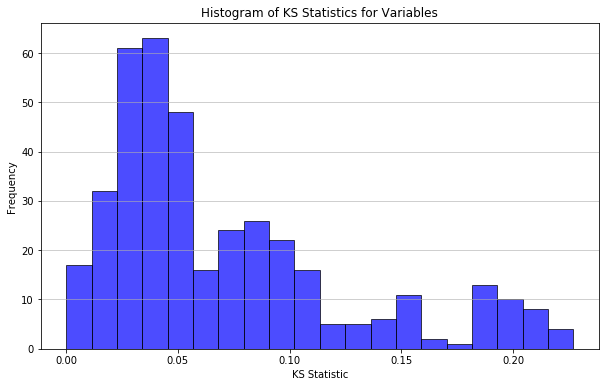

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(np.reshape(list(ks_vars.values()), -1), bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
plt.title('Histogram of KS Statistics for Variables')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [30]:
# We choose a cut-off of 0.05, as this removes a lot of the large differences, but keeps a lot of options still
chosen_vars = []
for var in ks_vars.keys():
    if ks_vars[var][0] < 0.05:
        chosen_vars.append(var)

Great, we are left with all variables that could help to discriminate between signal and background. The second step of feature selection is identifying the discriminatory power of each remaining variable.

**Ex. 3.2: Define a metric to quantify discriminating power and choose the best features to use in a classification algorithm.**

<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">This is very similar to Ex. 3.1.</a></h4>

In [31]:
bkg_sample = data_signal[data_signal["B_FitDaughtersConst_M_flat"]> best_high]

In [32]:
# We use the KS statistic again, but in this case to calculate the difference between signal and background
ks_vars_sep = {}
for var in tqdm(chosen_vars):
    ks_vars_sep[var] = [ks_test_variable(var, b_zero, b_zero["kinematic_weights"], bkg_sample, np.ones(len(bkg_sample)))]

100%|██████████| 200/200 [00:33<00:00,  8.85it/s]


In [33]:
ks_vars_sep

{'B_LOKI_ENERGY': [0.15168092206594286],
 'B_LOKI_ETA': [0.21533793315317945],
 'B_LOKI_PHI': [0.004666259300787179],
 'B_Vtx_Chi2NDOF': [0.46143883093677607],
 'B_MINIP': [0.6959152604429057],
 'B_MINIPCHI2': [0.6985263215578669],
 'B_ENDVERTEX_CHI2': [0.46143883093677607],
 'B_OWNPV_CHI2': [0.334446575433427],
 'B_OWNPV_NDOF': [0.287189509577849],
 'B_IP_OWNPV': [0.697628563839112],
 'B_IPCHI2_OWNPV': [0.6985263215578669],
 'B_FDCHI2_OWNPV': [0.4878064130341964],
 'B_TOPPV_CHI2': [0.334446575433427],
 'B_TOPPV_NDOF': [0.287189509577849],
 'B_IP_TOPPV': [0.697628563839112],
 'B_IPCHI2_TOPPV': [0.6985263215578669],
 'B_FDCHI2_TOPPV': [0.4878064130341964],
 'B_P': [0.15183956732783432],
 'B_PT': [0.34752410895730745],
 'B_PE': [0.15168092206594286],
 'B_TAUCHI2': [0.6984769648796585],
 'B_LOKI_DTF_CHI2NDOF': [0.6957760245960145],
 'B_LOKI_DTF_VCHI2NDOF': [0.6957760245960145],
 'B_LOKI_FDCHI2': [0.4878064130341964],
 'B_FitDaughtersConst_KS0_M_flat': [0.2473345861389403],
 'B_FitDaughter

In [34]:
# We choose a cut-off of 0.20
chosen_vars_sep = []
for var in ks_vars_sep.keys():
    if ks_vars_sep[var][0] > 0.20:
        chosen_vars_sep.append(var)

In [35]:
len(chosen_vars_sep)

93

In [36]:
chosen_vars_sep

['B_LOKI_ETA',
 'B_Vtx_Chi2NDOF',
 'B_MINIP',
 'B_MINIPCHI2',
 'B_ENDVERTEX_CHI2',
 'B_OWNPV_CHI2',
 'B_OWNPV_NDOF',
 'B_IP_OWNPV',
 'B_IPCHI2_OWNPV',
 'B_FDCHI2_OWNPV',
 'B_TOPPV_CHI2',
 'B_TOPPV_NDOF',
 'B_IP_TOPPV',
 'B_IPCHI2_TOPPV',
 'B_FDCHI2_TOPPV',
 'B_PT',
 'B_TAUCHI2',
 'B_LOKI_DTF_CHI2NDOF',
 'B_LOKI_DTF_VCHI2NDOF',
 'B_LOKI_FDCHI2',
 'B_FitDaughtersConst_KS0_M_flat',
 'B_FitDaughtersConst_chi2_flat',
 'B_FitDaughtersConst_psi_2S_M_flat',
 'B_FitDaughtersPVConst_KS0_M_flat',
 'B_FitDaughtersPVConst_chi2_flat',
 'B_FitDaughtersPVConst_psi_2S_M_flat',
 'B_FitJpsiConst_chi2_flat',
 'B_FitJpsiConst_psi_2S_M_flat',
 'B_FitJpsiPVConst_chi2_flat',
 'B_FitJpsiPVConst_psi_2S_M_flat',
 'B_FitPVConst_chi2_flat',
 'B_FitPVConst_psi_2S_M_flat',
 'B_FitwithoutConst_chi2_flat',
 'B_FitwithoutConst_psi_2S_M_flat',
 'psi_2S_Vtx_Chi2NDOF',
 'psi_2S_ENDVERTEX_CHI2',
 'psi_2S_OWNPV_CHI2',
 'psi_2S_OWNPV_NDOF',
 'psi_2S_TOPPV_CHI2',
 'psi_2S_TOPPV_NDOF',
 'psi_2S_FDCHI2_TOPPV',
 'psi_2S_ORIVX_CH

Now, you should have a set of variables that is well simulated and provides good discrimination between signal and background. Before we move on, you should check whether these features are uncorrelated to the invariant mass of the $B_s$ candidate.

**Ex. 3.3: Compute the correlation between your features and the invariant $B_s$ mass and remove features from your set if they are too correlated.**

In [37]:
sim_signal = get_data(path_to_sim)

In [38]:
# We'll compute the absolute Pearson correlation with the invariant mass
# and remove features with |corr| > 0.1 (you can adjust this threshold)

corr_threshold = 0.1
mass_var = "B_FitDaughtersConst_M_flat"

# Use the signal simulation for this check
corrs = {}
for var in chosen_vars_sep:
    if var == mass_var:
        continue
    corr = np.abs(np.corrcoef(sim_signal[var], sim_signal[mass_var])[0, 1])
    corrs[var] = corr

# Filter out highly correlated features
final_features = [var for var in chosen_vars_sep if corrs.get(var, 0) < corr_threshold]

print("Correlations with invariant mass:")
for var, corr in corrs.items():
    print(f"{var}: {corr:.3f}")

print("\nFeatures kept (|corr| < {:.2f}):".format(corr_threshold))
print(final_features)

Correlations with invariant mass:
B_LOKI_ETA: 0.002
B_Vtx_Chi2NDOF: 0.048
B_MINIP: 0.005
B_MINIPCHI2: 0.002
B_ENDVERTEX_CHI2: 0.048
B_OWNPV_CHI2: 0.001
B_OWNPV_NDOF: 0.001
B_IP_OWNPV: 0.004
B_IPCHI2_OWNPV: 0.002
B_FDCHI2_OWNPV: 0.004
B_TOPPV_CHI2: 0.001
B_TOPPV_NDOF: 0.001
B_IP_TOPPV: 0.004
B_IPCHI2_TOPPV: 0.002
B_FDCHI2_TOPPV: 0.004
B_PT: 0.004
B_TAUCHI2: 0.001
B_LOKI_DTF_CHI2NDOF: 0.001
B_LOKI_DTF_VCHI2NDOF: 0.001
B_LOKI_FDCHI2: 0.004
B_FitDaughtersConst_KS0_M_flat: 0.008
B_FitDaughtersConst_chi2_flat: 0.103
B_FitDaughtersConst_psi_2S_M_flat: 0.028
B_FitDaughtersPVConst_KS0_M_flat: 0.000
B_FitDaughtersPVConst_chi2_flat: 0.002
B_FitDaughtersPVConst_psi_2S_M_flat: 0.000
B_FitJpsiConst_chi2_flat: 0.015
B_FitJpsiConst_psi_2S_M_flat: 0.029
B_FitJpsiPVConst_chi2_flat: 0.002
B_FitJpsiPVConst_psi_2S_M_flat: 0.000
B_FitPVConst_chi2_flat: 0.001
B_FitPVConst_psi_2S_M_flat: 0.007
B_FitwithoutConst_chi2_flat: 0.048
B_FitwithoutConst_psi_2S_M_flat: 0.029
psi_2S_Vtx_Chi2NDOF: 0.006
psi_2S_ENDVERTEX

In [39]:
len(final_features)

92

In [40]:
# Discard features with high correlations among themselves
# We can use a threshold of 0.6 for this
corr_matrix = sim_signal[final_features].corr().abs()
corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_var = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.6)]
print("Highly correlated features (|corr| > 0.6):")
for var in high_corr_var:
    print(var)
print("\nFeatures kept (|corr| < 0.6):")
final_features = [var for var in final_features if var not in high_corr_var]
print(final_features)
print(f"Number of features after removing highly correlated ones: {len(final_features)}")

Highly correlated features (|corr| > 0.6):
B_MINIPCHI2
B_ENDVERTEX_CHI2
B_OWNPV_NDOF
B_IP_OWNPV
B_IPCHI2_OWNPV
B_TOPPV_CHI2
B_TOPPV_NDOF
B_IP_TOPPV
B_IPCHI2_TOPPV
B_FDCHI2_TOPPV
B_TAUCHI2
B_LOKI_DTF_CHI2NDOF
B_LOKI_DTF_VCHI2NDOF
B_LOKI_FDCHI2
B_FitDaughtersPVConst_chi2_flat
B_FitJpsiConst_chi2_flat
B_FitJpsiConst_psi_2S_M_flat
B_FitJpsiPVConst_chi2_flat
B_FitJpsiPVConst_psi_2S_M_flat
B_FitPVConst_chi2_flat
B_FitwithoutConst_chi2_flat
B_FitwithoutConst_psi_2S_M_flat
psi_2S_ENDVERTEX_CHI2
psi_2S_OWNPV_CHI2
psi_2S_OWNPV_NDOF
psi_2S_TOPPV_CHI2
psi_2S_TOPPV_NDOF
psi_2S_FDCHI2_TOPPV
psi_2S_ORIVX_CHI2
psi_2S_MM
psi_2S_M
muplus_MINIPCHI2
muplus_OWNPV_CHI2
muplus_OWNPV_NDOF
muplus_IP_OWNPV
muplus_IPCHI2_OWNPV
muplus_TOPPV_CHI2
muplus_TOPPV_NDOF
muplus_IP_TOPPV
muplus_IPCHI2_TOPPV
muplus_ORIVX_CHI2
muplus_IPCHI2_ORIVX
muminus_MINIPCHI2
muminus_OWNPV_CHI2
muminus_OWNPV_NDOF
muminus_IP_OWNPV
muminus_IPCHI2_OWNPV
muminus_TOPPV_CHI2
muminus_TOPPV_NDOF
muminus_IP_TOPPV
muminus_IPCHI2_TOPPV
muminus_OR

##### 4. Training a classification algorithm!

Now we have everything we need to train our classification algorithm. Awesome!

**Again, this section is a rather close guide to training a BDT. As before, feel free to ignore the exercises and define a classification algorithm deviating from the help provided. If you are feeling especially curious, try out other binary classification algorithms too.**

I suggest to use the [XGBoost](https://github.com/dmlc/xgboost) implementation of a [Boosted](https://en.wikipedia.org/wiki/Gradient_boosting) [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) for starters.

A BDT is a [supervised learning algorithm](https://en.wikipedia.org/wiki/Supervised_learning). This means that it needs to know to which category its input truely belongs. Therefore, we need to define labels for each event. The proposed implementation of a BDT takes an array of training samples and a list containing the corresponding label. 

**Ex 4.1: Define training sample and labels**

In [41]:
# Prepare training samples and labels using the selected features

# Signal: B^0 simulation (b_zero), use kinematic_weights
signal_X = b_zero[final_features]
signal_y = np.ones(len(signal_X))  # label 1 for signal

# Background: upper sideband from data (bkg_sample), use weight 1
background_X = bkg_sample[final_features]
background_y = np.zeros(len(background_X))  # label 0 for background

# Concatenate signal and background
training_samples = pd.concat([signal_X, background_X], ignore_index=True)
training_labels = np.concatenate([signal_y, background_y])

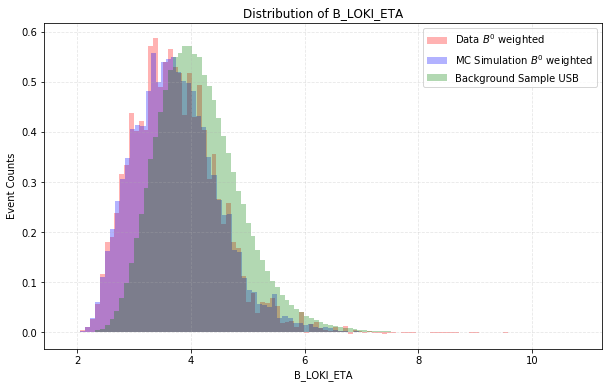

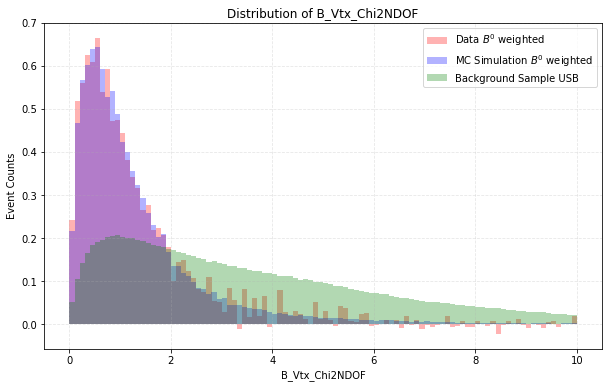

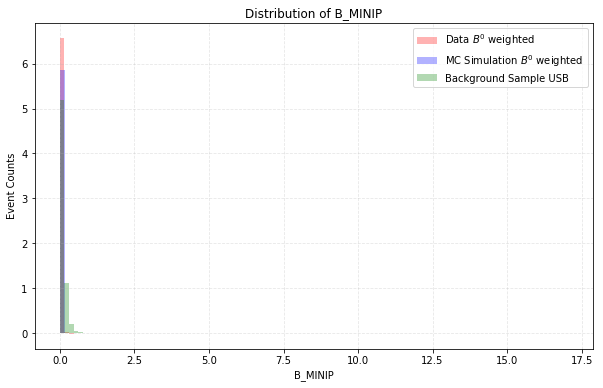

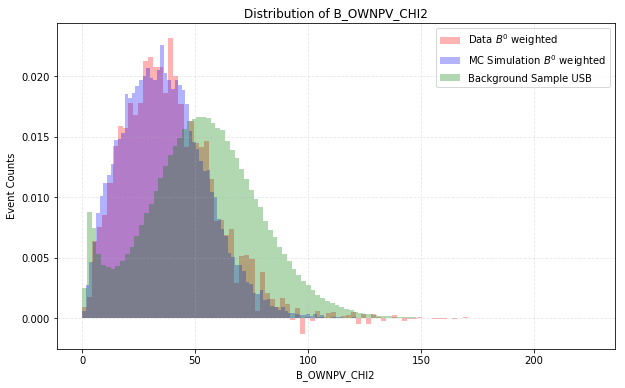

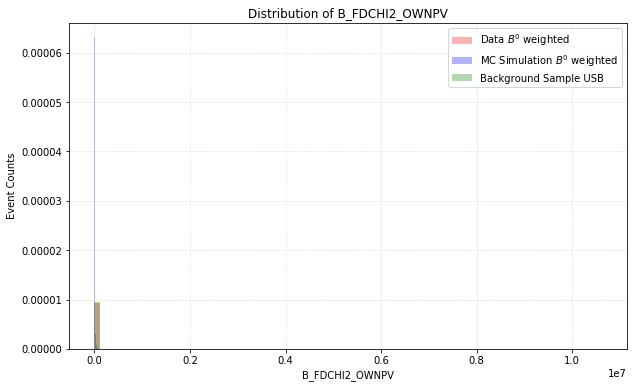

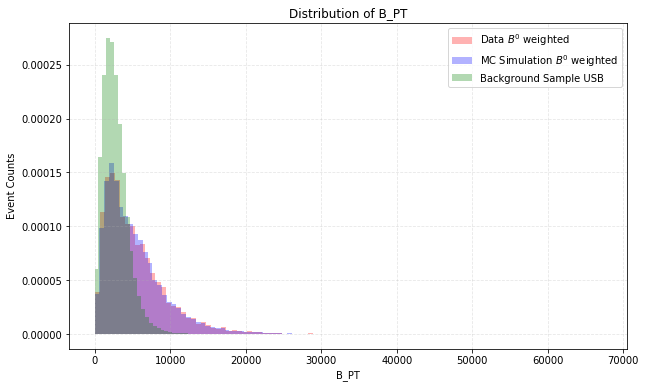

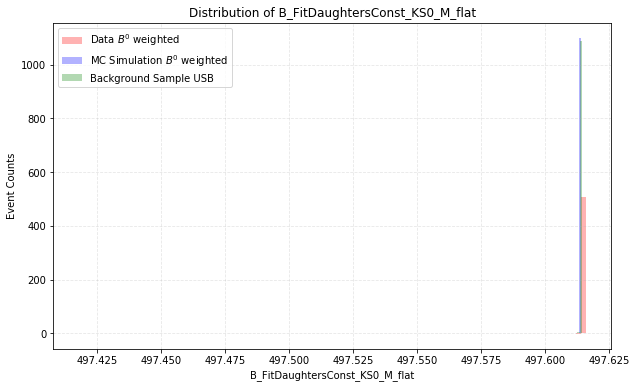

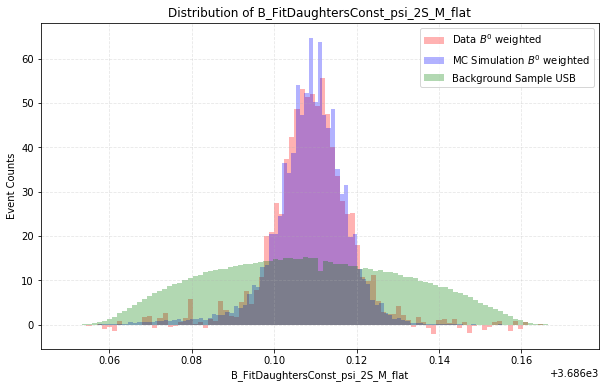

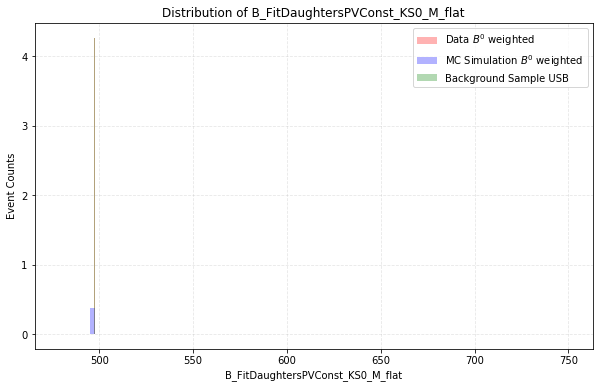

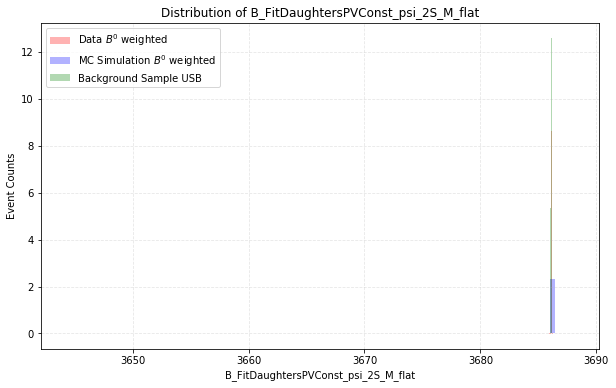

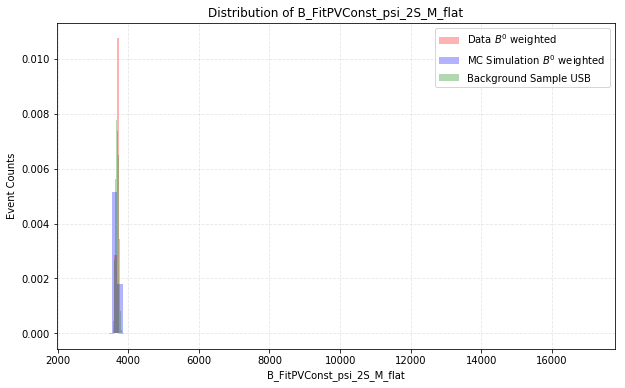

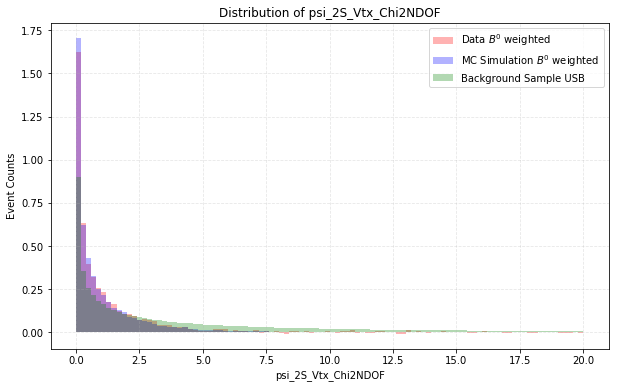

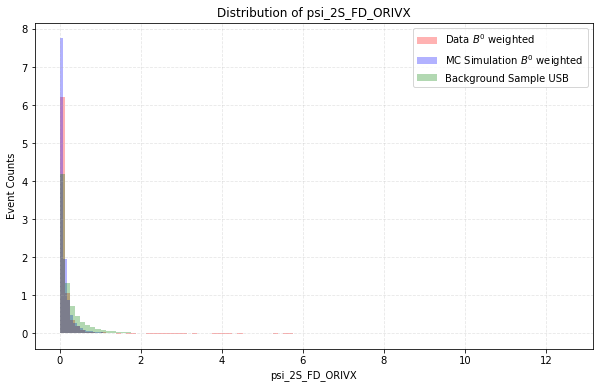

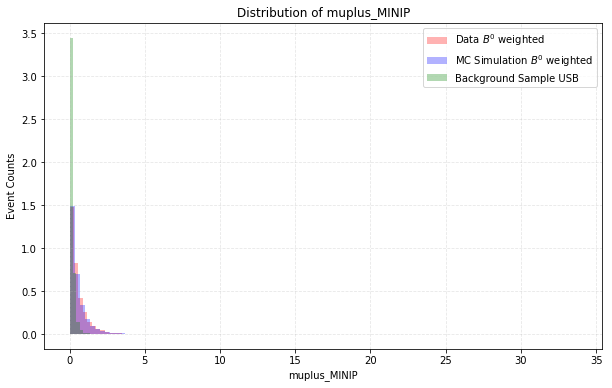

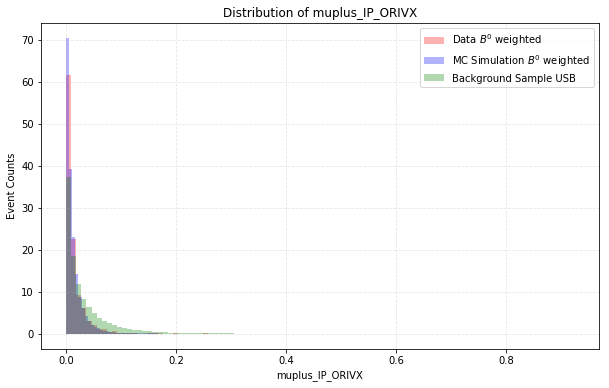

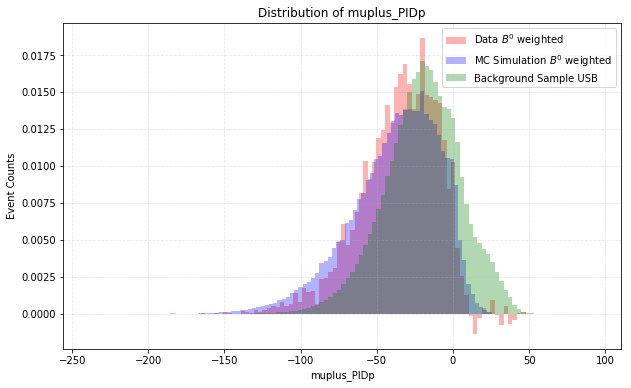

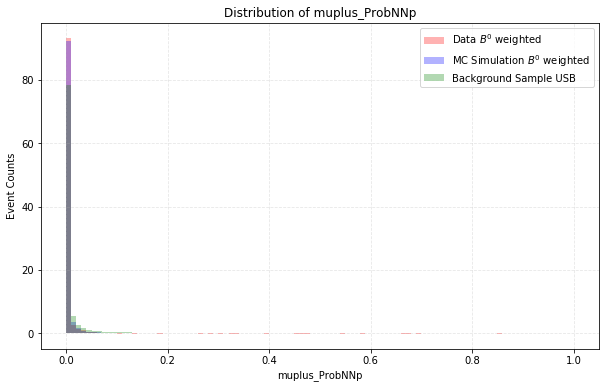

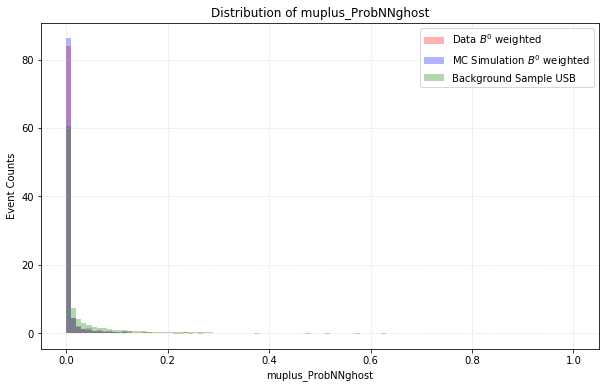

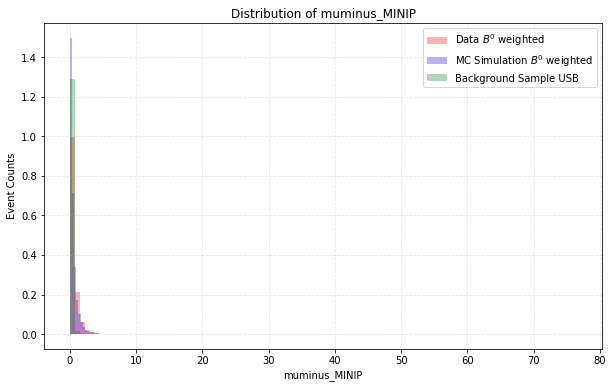

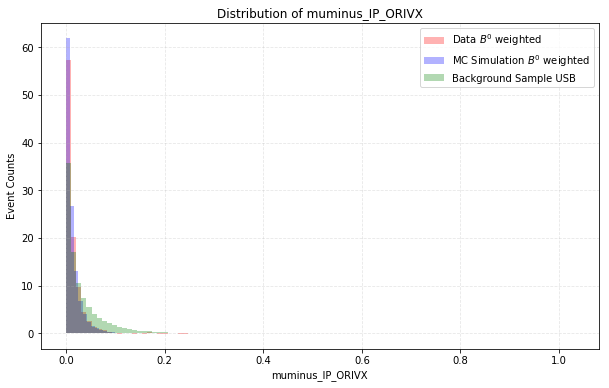

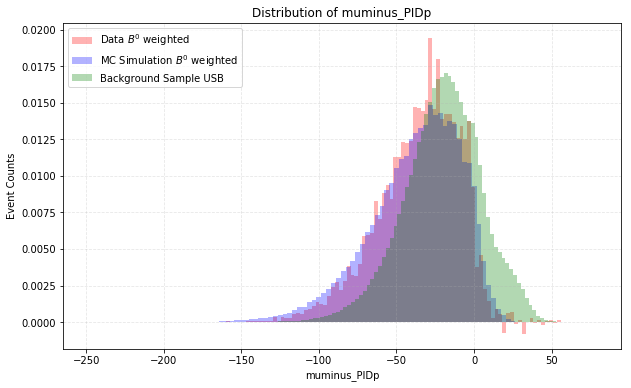

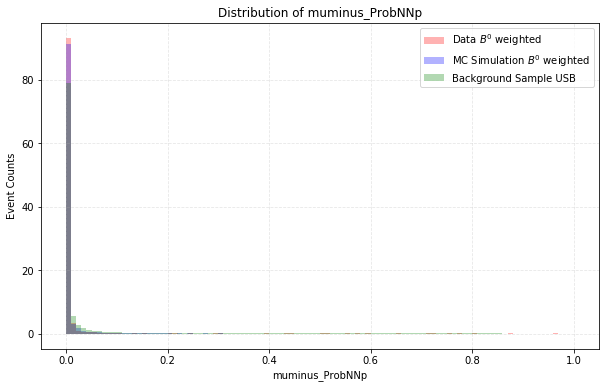

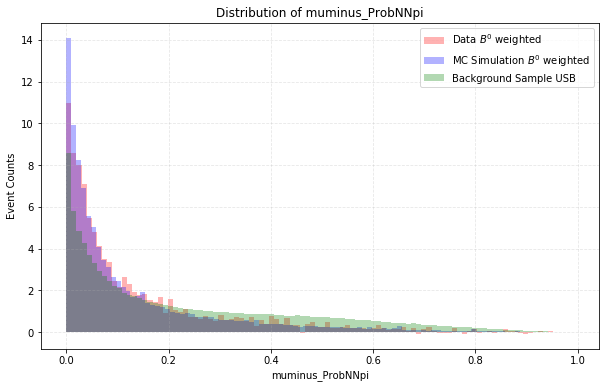

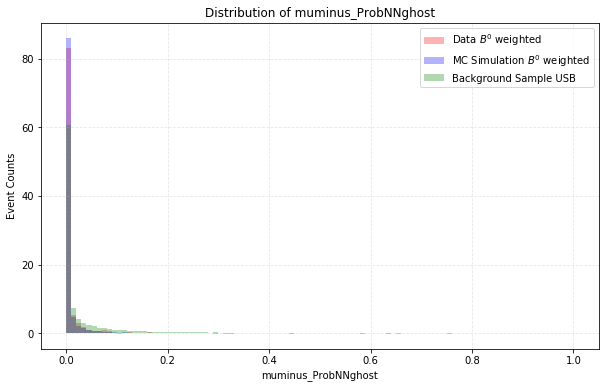

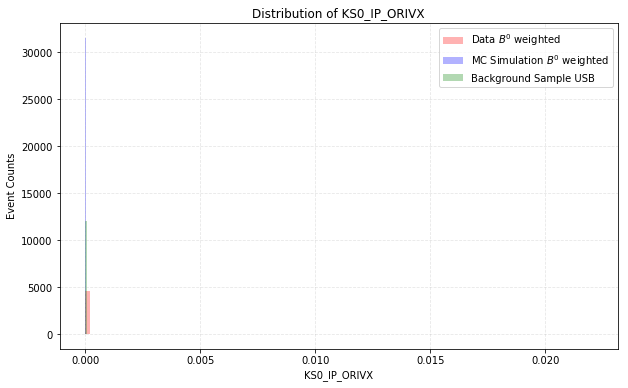

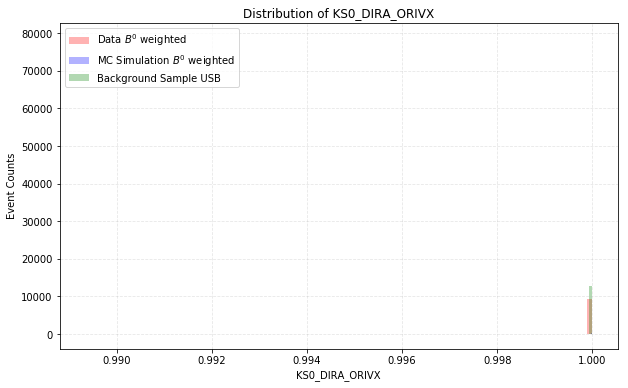

In [42]:
# Plot the the final features for background, signal, data control and MC control in the same plot
def plot_feature_distribution(feature, data_signal, b_zero, bkg_sample):
    plt.figure(figsize=(10, 6))
    plt.hist(data_signal[feature], weights=data_signal["sweights_sig"], density= True, bins=100, color="red", alpha=0.3, label="Data $B^0$ weighted")
    plt.hist(b_zero[feature], weights=b_zero["kinematic_weights"], density= True, bins=100, color="blue", alpha=0.3, label="MC Simulation $B^0$ weighted")
    plt.hist(bkg_sample[feature], density= True, bins=100, color="green", alpha=0.3, label="Background Sample USB")
    plt.xlabel(feature)
    plt.ylabel("Event Counts")
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.title(f"Distribution of {feature}")
    plt.show()
# Plot the distributions for all final features
for feature in final_features:
    plot_feature_distribution(feature, data_signal, b_zero, bkg_sample)

There is way more entries in our background sample than in the signal simulation. If these numbers are too unbalanced, classification algorithms may run into problems. Consider for instance a training set with 99% background. By simply classifiying the entire sample as background, the algorithm achieves 99% accuracy. That's not very useful.
Therefore, we assign a weight to each background event to make them "less important" in the training, while still taking advantage of the full backround sample.

**Ex 4.2: Define suitable weights for the background sample**

<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">50/50 is never a bad choice.</a></h4>

In [43]:
# Number of signal and background events
n_signal = len(signal_X)
n_background = len(background_X)

# Signal weights: use kinematic_weights from MC
signal_weights = b_zero["kinematic_weights"].values

# Background weights: scale so total background weight equals total signal weight
background_weight_value = np.sum(signal_weights) / n_background
background_weights = np.full(n_background, background_weight_value)

# Concatenate weights for training
training_weights = np.concatenate([signal_weights, background_weights])

If you choose to use the implementation proposed above, you can define and train a BDT like this:

In [44]:
from xgboost import XGBClassifier
if retrain:
    bdt = XGBClassifier()
    bdt.fit(training_samples,
            training_labels,
            sample_weight = training_weights,
           )

In [45]:
import pickle
if retrain:
    with open('bigBDT.pkl', 'wb') as f:
        pickle.dump(bdt, f)

# Load the BDT
with open('bigBDT.pkl', 'rb') as f:
    bdt = pickle.load(f)

The array of (signal and background) training samples is called `training_samples`, the list of labels is called `training_labels`, and the weights for each event is contained in the list `training_events`.

In order to avoid overtraining, we want split the data to train the classifier on one part and classify
only the "unseen" part. Since we do not want to "waste" any data just for testing,
we [cross-validate](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) using the implementation in `sklearn.model_selection.StratifiedKFold`.

**Make sure that you always apply the right BDT to the right training sample (the one you trained it on)!**

**Ex 4.3: Define a folding and train one BDT per fold, training on $\frac{n-1}{n}$ and testing on $\frac{1}{n}$ of the training data**

In [46]:
if retrain:
    from sklearn.model_selection import StratifiedKFold
    n_splits = 5  # You can adjust the number of folds
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    bdts = []
    fold_indices = []

    for train_idx, test_idx in skf.split(training_samples, training_labels):
        X_train, X_test = training_samples.iloc[train_idx], training_samples.iloc[test_idx]
        y_train, y_test = training_labels[train_idx], training_labels[test_idx]
        w_train = training_weights[train_idx]

        bdt_fold = XGBClassifier(verbosity = 2)
        bdt_fold.fit(X_train, y_train, sample_weight=w_train)
        bdts.append(bdt_fold)
        fold_indices.append((train_idx, test_idx))

In [47]:
# Save the trained BDTs and fold indices
if retrain:
    with open("bdts.pkl", "wb") as f:
        pickle.dump(bdts, f)
    with open("fold_indices.pkl", "wb") as f:
        pickle.dump(fold_indices, f)

# Load the trained BDTs and fold indices
with open("bdts.pkl", "rb") as f:
    bdts = pickle.load(f)
with open("fold_indices.pkl", "rb") as f:
    fold_indices = pickle.load(f)

As usual a plot can give you a quick idea of what you are doing is correct.

**Ex 4.4: Plot the distribution of the BDT output for the singal and background samples to visualize the classification.**
<h4>
Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z"> Make sure to apply the right BDT to the right sample. And a logarithmic scale may be useful again.
</a></h4>

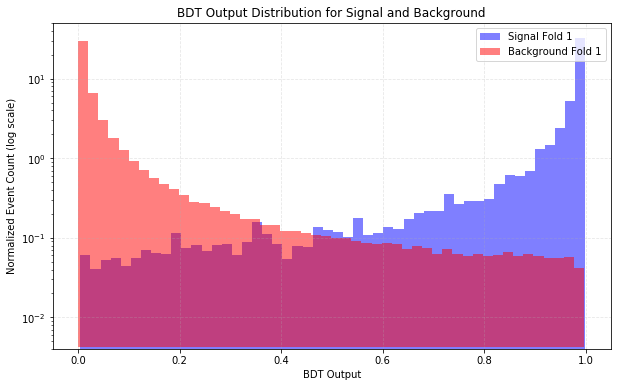

No handles with labels found to put in legend.


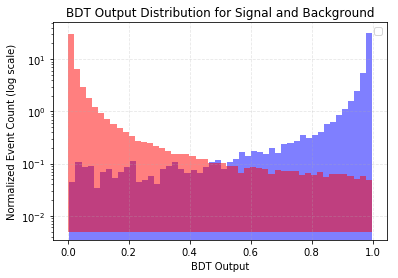

No handles with labels found to put in legend.


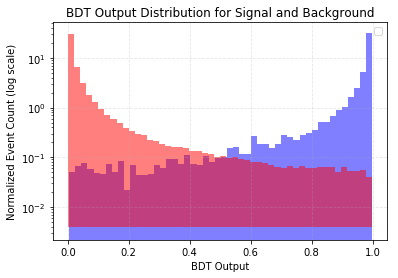

No handles with labels found to put in legend.


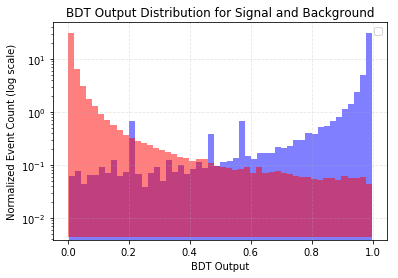

No handles with labels found to put in legend.


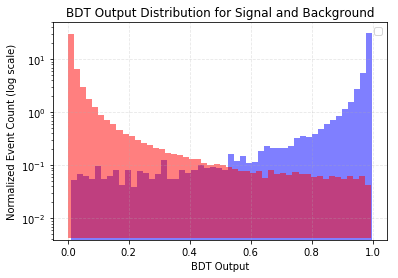

In [48]:
# Plot the BDT output distributions for signal and background, using the correct BDT for each fold
plt.figure(figsize=(10, 6))

for i, (bdt, (train_idx, test_idx)) in enumerate(zip(bdts, fold_indices)):
    # Get test samples and labels for this fold
    X_test = training_samples.iloc[test_idx]
    y_test = training_labels[test_idx]
    w_test = training_weights[test_idx]
    
    # Predict BDT output
    bdt_output = bdt.predict_proba(X_test)[:, 1]
    
    # Plot signal
    plt.hist(
        bdt_output[y_test == 1],
        bins=50,
        weights=w_test[y_test == 1],
        alpha=0.5,
        label=f"Signal Fold {i+1}" if i == 0 else None,
        color="blue",
        histtype="stepfilled",
        density=True,
        log=True
    )
    # Plot background
    plt.hist(
        bdt_output[y_test == 0],
        bins=50,
        weights=w_test[y_test == 0],
        alpha=0.5,
        label=f"Background Fold {i+1}" if i == 0 else None,
        color="red",
        histtype="stepfilled",
        density=True,
        log=True
    )
    plt.xlabel("BDT Output")
    plt.ylabel("Normalized Event Count (log scale)")
    plt.title("BDT Output Distribution for Signal and Background")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

Now that our model consisting of $n$ BDTs is trained, we want to check how well it did! As metric we choose to look at the [Reciever-Operating-Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and the area under its curve.

**Ex 4.5: Evaluate the performance of your classifier by plotting the ROC curve and calculating the area under the curve for every BDT you trained. Do not evaluate the signal region of the data yet.**
<h4>
Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">
Make sure you apply the right BDt to the right sample. Check out `sklearn` for an implementation of the ROC curve.
</a></h4>

In [49]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

def evaluate_classifier(y_true, y_score, threshold=0.5, sample_weight=None, plot=True):
    """
    Calculate ROC curve, AUC, and confusion matrix for a classifier, and optionally plot them.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score, sample_weight=sample_weight)
    auc_score = auc(fpr, tpr)
    y_pred = (y_score >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)

    if plot:
        # Plot ROC curve
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc='lower right')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.show()

        # Plot confusion matrix
        plt.figure(figsize=(4, 4))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['Background', 'Signal'])
        plt.yticks(tick_marks, ['Background', 'Signal'])
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        for i in range(2):
            for j in range(2):
                plt.text(j, i, int(cm[i, j]), ha='center', va='center', color='black')
        plt.tight_layout()
        plt.show()

    return fpr, tpr, thresholds, auc_score, cm

Evaluation for Fold 1:


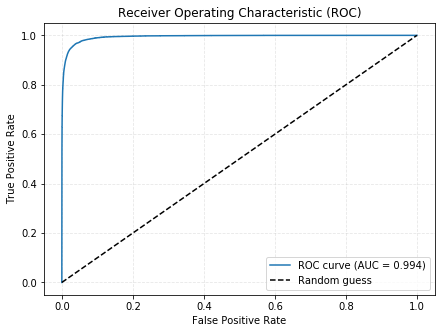

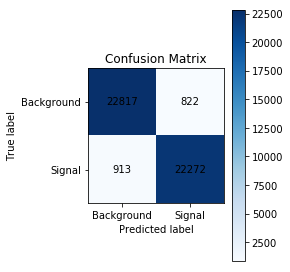

AUC: 0.994
Confusion Matrix:
[[22817.22621172   822.33164376]
 [  913.52269987 22272.22508217]]
Evaluation for Fold 2:


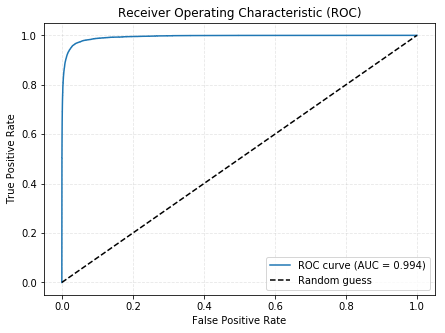

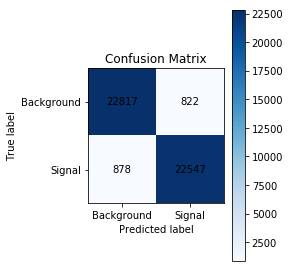

AUC: 0.994
Confusion Matrix:
[[22817.40968598   822.1481695 ]
 [  878.36295581 22547.50821094]]
Evaluation for Fold 3:


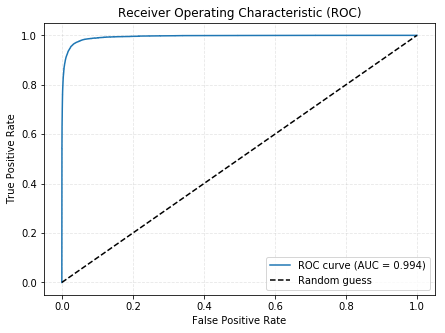

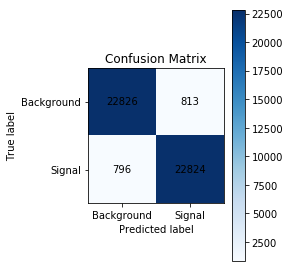

AUC: 0.994
Confusion Matrix:
[[22826.39992484   813.15793064]
 [  796.28080316 22824.95388633]]
Evaluation for Fold 4:


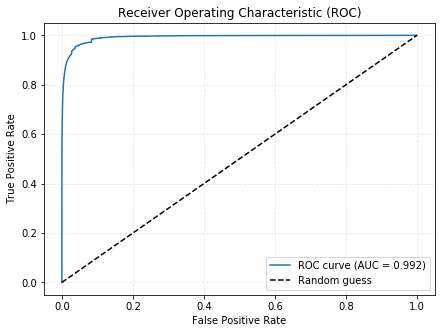

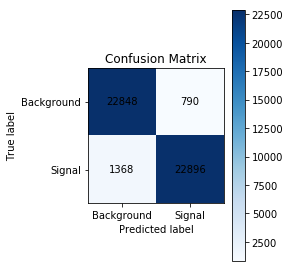

AUC: 0.992
Confusion Matrix:
[[22848.60031058   790.77407064]
 [ 1368.1172189  22896.1098944 ]]
Evaluation for Fold 5:


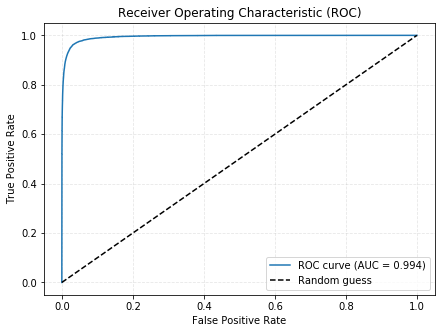

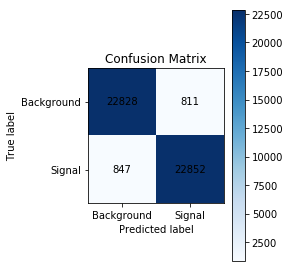

AUC: 0.994
Confusion Matrix:
[[22828.0511932    811.32318802]
 [  847.71925556 22852.62232179]]


In [50]:
# Implementing the evaluation function for each fold
for i, (bdt, (train_idx, test_idx)) in enumerate(zip(bdts, fold_indices)):
    # Get test samples and labels for this fold
    X_test = training_samples.iloc[test_idx]
    y_test = training_labels[test_idx]
    w_test = training_weights[test_idx]
    
    # Predict BDT output
    bdt_output = bdt.predict_proba(X_test)[:, 1]
    
    print(f"Evaluation for Fold {i+1}:")
    fpr, tpr, thresholds, auc_score, cm = evaluate_classifier(y_test, bdt_output, sample_weight=w_test)
    print(f"AUC: {auc_score:.3f}")
    print("Confusion Matrix:")
    print(cm)

## 5. Classification threshold optimization
Now that we have our predictions, we would like to define a value at which we split the datasets into signal and background. We go with the following definition of a measure for signal sensitivity/significance:   
$s = \frac{\epsilon_{sig}}{5/2 + \sqrt{n_{bkg}}}$,  
where $\epsilon_{sig}$ is the efficiency of our selection regarding signal and $n_{bkg}$ is the number of background events in the signal region.

We compute the significance for several possible splitting points from 0 to 1. Eventually, we choose the cut-off leading to the highest significance.

First though, we need to compute the signal efficiency and number of background events in the signal region serving as input to our FOM.

**Ex 5.1: Find a way to estimate the signal efficiency and the number of background events in the signal region(!) depending on the cut on the BDT output.**

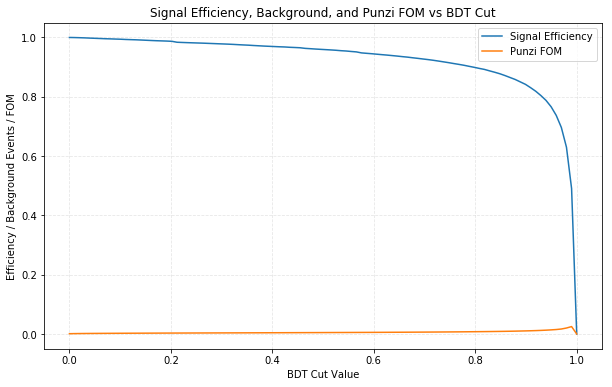

In [51]:
# Estimate signal efficiency, number of background events in the signal region, and Punzi FOM vs BDT cut,
# assuming the background is exponentially distributed in mass.

def estimate_signal_eff_and_bkg_vs_cut(bdts, fold_indices, training_samples, training_labels, training_weights,
                                       b_zero, bkg_sample, final_features, best_low, best_high, n_cuts=100):
    """
    For a range of BDT cut values, compute:
      - signal efficiency (fraction of MC signal events passing the cut)
      - number of background events in the signal region passing the cut (using exponential fit)
      - Punzi FOM: eps_sig / (5/2 + sqrt(n_bkg))
    Returns: cuts, signal_efficiencies, n_bkg_in_signal_region, punzi_fom
    """
    cuts = np.linspace(0, 1, n_cuts)
    signal_efficiencies = np.zeros(n_cuts)
    n_bkg_in_signal_region = np.zeros(n_cuts)
    punzi_fom = np.zeros(n_cuts)

    # 1. Fit exponential to background mass distribution (outside signal window)
    bkg_masses = bkg_sample["B_FitDaughtersConst_M_flat"].values
    fit_mask = bkg_masses > best_high
    fit_masses = bkg_masses[fit_mask]
    from scipy.optimize import curve_fit

    def exp_func(m, N, lamb):
        return N * np.exp(-lamb * m)

    hist, bin_edges = np.histogram(fit_masses, bins=50)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    popt, _ = curve_fit(exp_func, bin_centers, hist, p0=[np.max(hist), 1e-4])

    N_exp, lamb_exp = popt

    # 2. For each BDT cut, estimate signal efficiency and background in signal window
    for bdt, (train_idx, test_idx) in zip(bdts, fold_indices):
        # Signal MC test set
        X_sig = training_samples.iloc[test_idx][training_labels[test_idx] == 1]
        w_sig = training_weights[test_idx][training_labels[test_idx] == 1]
        if len(X_sig) == 0:
            continue
        bdt_output_sig = bdt.predict_proba(X_sig)[:, 1]
        for i, cut in enumerate(cuts):
            passed = bdt_output_sig >= cut
            signal_efficiencies[i] += np.sum(w_sig[passed]) / np.sum(w_sig)

        # Background: estimate fraction passing BDT cut in USB, then scale exponential integral in signal window
        X_bkg = training_samples.iloc[test_idx][training_labels[test_idx] == 0]
        w_bkg = training_weights[test_idx][training_labels[test_idx] == 0]
        bkg_offset = len(b_zero)
        bkg_indices = test_idx[training_labels[test_idx] == 0] - bkg_offset
        valid = (bkg_indices >= 0) & (bkg_indices < len(bkg_sample))
        if not np.any(valid):
            continue
        X_bkg_usb = X_bkg.iloc[valid]
        w_bkg_usb = w_bkg[valid]
        bdt_output_bkg = bdt.predict_proba(X_bkg_usb)[:, 1]
        for i, cut in enumerate(cuts):
            frac_pass = np.sum(w_bkg_usb[bdt_output_bkg >= cut]) / np.sum(w_bkg_usb)
            bkg_in_signal_window = N_exp / lamb_exp * (np.exp(-lamb_exp * best_low) - np.exp(-lamb_exp * best_high))
            n_bkg_in_signal_region[i] += frac_pass * bkg_in_signal_window

    signal_efficiencies /= len(bdts)
    n_bkg_in_signal_region /= len(bdts)
    punzi_fom = signal_efficiencies / (2.5 + np.sqrt(n_bkg_in_signal_region))

    return cuts, signal_efficiencies, n_bkg_in_signal_region, punzi_fom

# Example usage:
cuts, signal_efficiencies, n_bkg_in_signal_region, punzi_fom = estimate_signal_eff_and_bkg_vs_cut(
    bdts, fold_indices, training_samples, training_labels, training_weights,
    b_zero, bkg_sample, final_features, best_low, best_high
)

plt.figure(figsize=(10,6))
plt.plot(cuts, signal_efficiencies, label="Signal Efficiency")
#plt.plot(cuts, n_bkg_in_signal_region, label="Background Events in Signal Region (exp. model)")
plt.plot(cuts, punzi_fom, label="Punzi FOM")
plt.xlabel("BDT Cut Value")
plt.ylabel("Efficiency / Background Events / FOM")
plt.title("Signal Efficiency, Background, and Punzi FOM vs BDT Cut")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

Calculating all BDT outputs.


  1%|          | 7/1000 [00:00<00:14, 67.39it/s]

Calculated all BDT outputs. Starting threshold value calculations


100%|██████████| 1000/1000 [00:11<00:00, 90.81it/s]


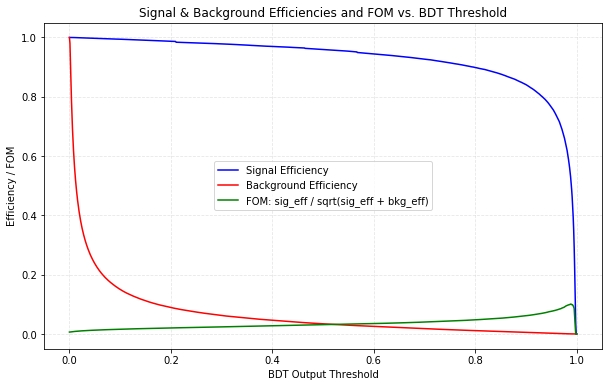

In [52]:
# Calculate and plot signal efficiency, background efficiency, and FOM for a range of BDT thresholds

thresholds = np.linspace(0, 1, 1000)
signal_efficiencies = []
background_efficiencies = []
fom_values = []

bdt_outputs = []
y_tests = []
w_tests = []

print("Calculating all BDT outputs.")
for bdt, (train_idx, test_idx) in zip(bdts, fold_indices):
        X_test = training_samples.iloc[test_idx]
        y_test = training_labels[test_idx]
        y_tests.append(y_test)
        w_test = training_weights[test_idx]
        w_tests.append(w_test)
        bdt_output = bdt.predict_proba(X_test)[:, 1]
        bdt_outputs.append(bdt_output)

print("Calculated all BDT outputs. Starting threshold value calculations")
# Use cross-validation folds to average the results
for thresh in tqdm(thresholds):
    sig_eff_fold = []
    bkg_eff_fold = []
    fom_fold = []
    for bdt_output, y_test, w_test in zip(bdt_outputs, y_tests, w_tests):

        # Signal and background masks
        sig_mask = (y_test == 1)
        bkg_mask = (y_test == 0)

        # Signal efficiency: fraction of signal events above threshold (weighted)
        sig_selected = (bdt_output[sig_mask] > thresh)
        sig_eff = np.sum(w_test[sig_mask][sig_selected]) / np.sum(w_test[sig_mask])

        # Background efficiency: fraction of background events above threshold (weighted)
        bkg_selected = (bdt_output[bkg_mask] > thresh)
        bkg_eff = np.sum(w_test[bkg_mask][bkg_selected]) / np.sum(w_test[bkg_mask])

        # Number of background events above threshold (weighted sum)
        n_bkg = np.sum(w_test[bkg_mask][bkg_selected])

        # Ponzi Figure of Merit (FOM)
        fom = sig_eff / (2.5 + np.sqrt(n_bkg)) if n_bkg > 0 else 0

        sig_eff_fold.append(sig_eff)
        bkg_eff_fold.append(bkg_eff)
        fom_fold.append(fom)

    # Average over folds
    signal_efficiencies.append(np.mean(sig_eff_fold))
    background_efficiencies.append(np.mean(bkg_eff_fold))
    fom_values.append(np.mean(fom_fold))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, signal_efficiencies, label="Signal Efficiency", color="blue")
plt.plot(thresholds, background_efficiencies, label="Background Efficiency", color="red")
plt.plot(thresholds, fom_values, label="FOM: sig_eff / sqrt(sig_eff + bkg_eff)", color="green")
plt.xlabel("BDT Output Threshold")
plt.ylabel("Efficiency / FOM")
plt.title("Signal & Background Efficiencies and FOM vs. BDT Threshold")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

**Ex 5.2: Determine the best cut value based on your just defined metric.**
<h4>
Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">
You could for example average the best cut values of the $n$ BDTs to combine them to a total value.
</a></h4>

Best BDT cut value: 0.990
Maximum FOM: 0.025
Signal efficiency at best cut: 0.994
Background events in signal region at best cut: 294.36


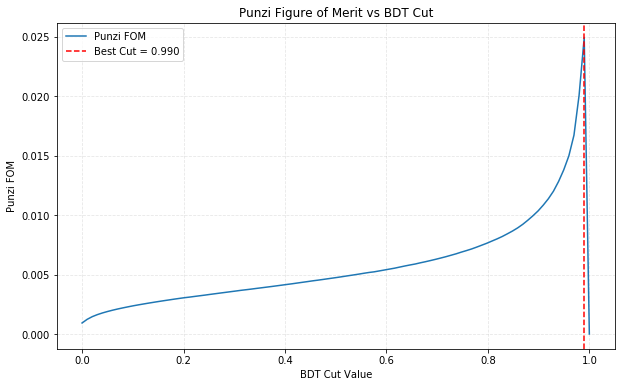

In [53]:
# Find the cut value that maximizes the Punzi FOM
best_cut_idx = np.argmax(punzi_fom)
best_cut = cuts[best_cut_idx]
print(f"Best BDT cut value: {best_cut:.3f}")
print(f"Maximum FOM: {punzi_fom[best_cut_idx]:.3f}")
print(f"Signal efficiency at best cut: {signal_efficiencies[best_cut_idx]:.3f}")
print(f"Background events in signal region at best cut: {n_bkg_in_signal_region[best_cut_idx]:.2f}")

# Plot FOM with the best cut highlighted
plt.figure(figsize=(10,6))
plt.plot(cuts, punzi_fom, label="Punzi FOM")
plt.axvline(best_cut, color='red', linestyle='--', label=f"Best Cut = {best_cut:.3f}")
plt.xlabel("BDT Cut Value")
plt.ylabel("Punzi FOM")
plt.title("Punzi Figure of Merit vs BDT Cut")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

## 6. Estimation of the number of $B_s$ events in the data sample
Now that we defined a best cut, lets apply our classification algorithm to the full dataset and see how well it works. We will then get the "real" signal significance by fitting the selected mass distribution.  


**Ex 6.1: Apply your classifier to the full dataset and plot the mass distribution.**

In [54]:
# loop over all BDTs and predict for all the events in the dataset
bdt_output_data = []

for bdt in bdts:
    bdt_output = bdt.predict_proba(data_signal[final_features])[:,1]
    bdt_output_data.append(bdt_output)
    
# average over all the BTD outputs
bdt_output_mean = np.mean(bdt_output_data, axis=0)

# apply the best cut value
cut_data = data_signal[bdt_output_mean>=best_cut]

print(f"The number of events that passed the cut is {cut_data.shape[0]} out of the entire dataset events {data_signal.shape[0]}.")

The number of events that passed the cut is 5712 out of the entire dataset events 1092793.


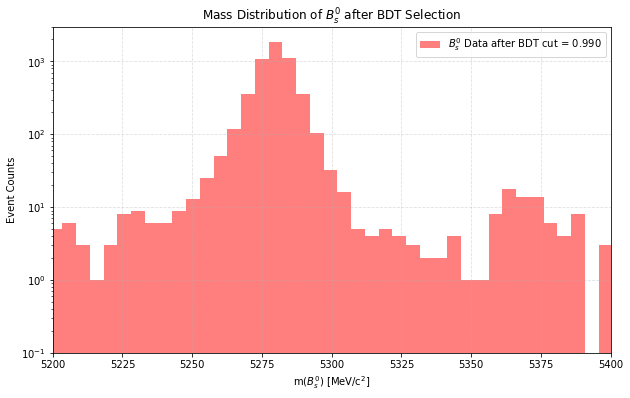

In [55]:
# plot the mass distribution of the selected events
plt.figure(figsize=(10,6))
plt.hist(
    cut_data["B_FitDaughtersConst_M_flat"],
    bins=200,
    histtype="stepfilled",
    color="red",
    alpha=0.5,
    log=True,
    label=r"$B_{s}^0$ Data after BDT cut = 0.990"
)
plt.xlabel(r"m($B_{s}^0$) [MeV/c$^2$]")
plt.xlim(5200,5400)
plt.ylabel("Event Counts")
plt.title(r"Mass Distribution of $B_{s}^0$ after BDT Selection ")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [56]:
data_here = cut_data["B_FitDaughtersConst_M_flat"]
counts, bin_edges = np.histogram(data_here, bins=50)
max_bin_index = np.argmax(counts)
peak = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1])/2
print(f"The highest peak is at {peak:.2f} MeV.")

The highest peak is at 5287.25 MeV.


You should see two peaks when plotting on a log-scale.

Now we have to find out what efficiency vs background retention we are getting here. Therefore, we need to model the entire distribution. This model should consist of two peaking structures ($B^0$ and $B_s$) and one exponential background component. To build a stable model, we first fit the peaks to their respective simulation and fix the obtained shape parameters in the fit to data. To ensure that the peaks in simulation match the peak shape in data, you need to classify both signal samples and apply the BDT cut before performing the fit.

I recommend using the [`zfit`](https://zfit.readthedocs.io/en/latest/) library for fitting. But again, this is just one of many good choices that you are free to take.

**Ex 6.2: Fit a peak to the signal simulation.**
<h4>Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z"> Maybe ONE Gaussian is not enough?</a></h4>

In [57]:
# first we apply the classifier to the MC simulated signal
bdt_output_sim = []

for bdt in bdts:
    bdt_output = bdt.predict_proba(sim_signal[final_features])[:,1]
    bdt_output_sim.append(bdt_output)
    
bdt_output_sim_mean = np.mean(bdt_output_sim, axis=0)

cut_sim = sim_signal[bdt_output_sim_mean >= best_cut]

print(f"The number of events that passed the BDT cut is {cut_sim.shape[0]}, out of the full events in the simulation {sim_signal.shape[0]}.")

The number of events that passed the BDT cut is 115903, out of the full events in the simulation 213294.


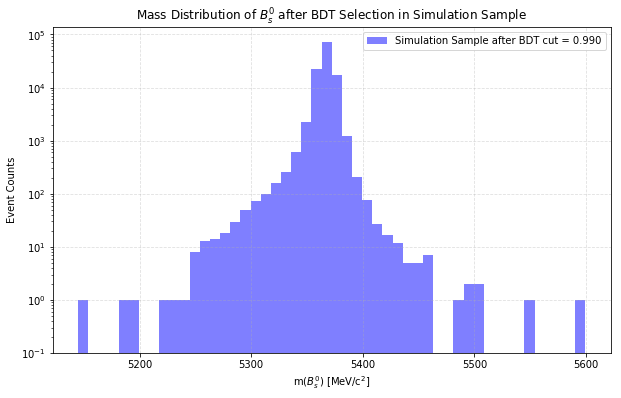

In [58]:
# plot the mass distribution in the simulation sample to estimate the ranges for the fit parameters
plt.figure(figsize=(10,6))
plt.hist(
    cut_sim["B_FitDaughtersConst_M_flat"],
    bins=50,
    histtype="stepfilled",
    color="blue",
    alpha=0.5,
    log=True,
    label="Simulation Sample after BDT cut = 0.990"
)
plt.xlabel(r"m($B_{s}^0$) [MeV/c$^2$]")
plt.ylabel("Event Counts")
plt.title(r"Mass Distribution of $B_{s}^0$ after BDT Selection in Simulation Sample")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [59]:
data_sim = cut_sim["B_FitDaughtersConst_M_flat"]
counts, bin_edges = np.histogram(data_sim, bins=50)
max_bin_index = np.argmax(counts)
peak = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1])/2
print(f"The peak is at {peak:.2f} MeV.")

The peak is at 5367.65 MeV.


In [60]:
import tensorflow as tf
import zfit 
from zfit import z

In [61]:
# define our observable which is the mass
observable = zfit.Space("mass", limits=(5300, 5420))
mass_values = cut_sim["B_FitDaughtersConst_M_flat"].values
sim_data = zfit.Data.from_numpy(obs=observable, array=mass_values)

In [62]:
# define the parameters
mu = zfit.Parameter("mu", 5367.65, 5360, 5375) # first value is a starting guess, then the lower limit and upper limit
sigma1 = zfit.Parameter("sigma1", 10, 2, 25)  # narrow Gaussian
sigma2 = zfit.Parameter("sigma2", 20, 10, 80)  # wide tail Gaussian
f = zfit.Parameter("f", 0.9, 0.5, 0.99)  # this is the fractional contribution of the narrow Gaussian

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [63]:
gauss1 = zfit.pdf.Gauss(obs=observable, mu=mu, sigma=sigma1)
gauss2 = zfit.pdf.Gauss(obs=observable, mu=mu, sigma=sigma2)
sim_model = zfit.pdf.SumPDF([gauss1, gauss2], fracs=[f])

# create the loss function, an unbinned negative log-likelihood
nll = zfit.loss.UnbinnedNLL(model=sim_model, data=sim_data)

# instantiate a minimizer (in this case a basic minuit minimizer)
minimizer = zfit.minimize.Minuit()

# minimize the negative log-likelihood
result = minimizer.minimize(nll)

#calculate Hesse errors
hesse_errors = result.hesse()

# print the fit parameters information
print("Fit converged:", result.converged)
print("\n Fit paramters: \n")
print(f"mu: {result.params[mu]['value']:.3f} ± {hesse_errors[mu]['error']:.3f}")
print(f"sigma1: {result.params[sigma1]['value']:.3f} ± {hesse_errors[sigma1]['error']:.3f}")
print(f"sigma2: {result.params[sigma2]['value']:.3f} ± {hesse_errors[sigma2]['error']:.3f}")
print(f"f: {result.params[f]['value']:.3f} ± {hesse_errors[f]['error']:.3f}")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
------------------------------------------------------------------
| FCN = 3.737E+05               |      Ncalls=82 (82 total)      |
| EDM = 1.59E-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------

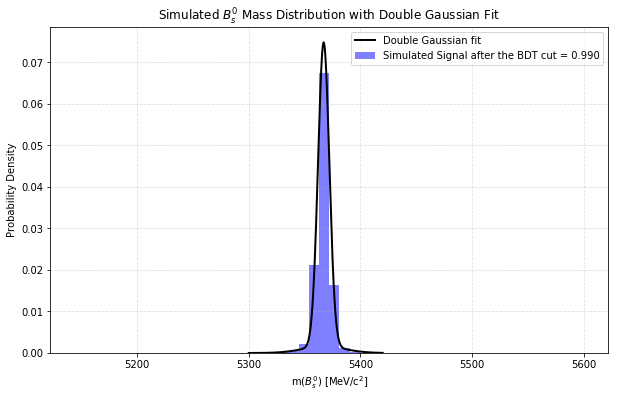

In [64]:
# plot to see how it looks
plt.figure(figsize=(10,6))

observable = zfit.Space("mass", limits=(5300, 5420))
mass_values = cut_sim["B_FitDaughtersConst_M_flat"].values

# plot the cut simulated mass data histogram
plt.hist(mass_values,
         bins=50, 
         histtype="stepfilled", color="blue", alpha=0.5, 
         density=True, label="Simulated Signal after the BDT cut = 0.990")

# plot the fit model
x = np.linspace(5300, 5420, 500)
x_fit = zfit.Data.from_numpy(obs=observable, array=x)
pdf = zfit.run(sim_model.pdf(x_fit))

plt.plot(
    x,
    pdf,  
    color="black",
    alpha=1,
    linestyle="-",
    linewidth=2,
    label="Double Gaussian fit"
)

plt.xlabel(r"m($B_{s}^0$) [MeV/c$^2$]")
plt.ylabel("Probability Density")
plt.title(r"Simulated $B_{s}^0$ Mass Distribution with Double Gaussian Fit")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

Now that you have the shape parameters of the signal mass peak, we do the same for the $B^0$ peak.

**Ex 6.3: Fit a peak to the BDT selected $B^0$ simulation.**

In [65]:
# apply the classifier to the B0 simulation
bdt_output_bzero = []

for bdt in bdts:
    bdt_output = bdt.predict_proba(b_zero[final_features])[:,1]
    bdt_output_bzero.append(bdt_output)
    
# average over all the BTD outputs
bdt_output_bzero_mean = np.mean(bdt_output_bzero, axis=0)

# apply the best cut value >= 0.99
cut_bzero = b_zero[bdt_output_bzero_mean>=0.99]

print(f"The number of events that passed the cut is {cut_bzero.shape[0]} out of the entire dataset events {b_zero.shape[0]}.")

The number of events that passed the cut is 83430 out of the entire dataset events 155430.


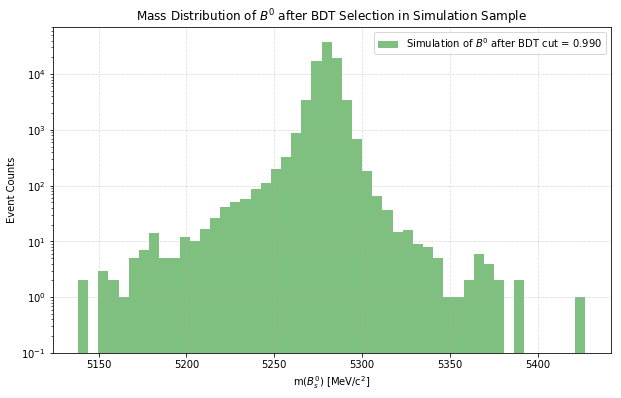

In [66]:
# plot the mass distribution in the simulation sample to estimate the ranges for the fit parameters
plt.figure(figsize=(10,6))
plt.hist(
    cut_bzero["B_FitDaughtersConst_M_flat"],
    bins=50,
    histtype="stepfilled",
    color="green",
    alpha=0.5,
    log=True,
    label=r"Simulation of $B^0$ after BDT cut = 0.990"
)
plt.xlabel(r"m($B_{s}^0$) [MeV/c$^2$]")
plt.ylabel("Event Counts")
plt.title(r"Mass Distribution of $B^0$ after BDT Selection in Simulation Sample")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [67]:
data_bzero = cut_bzero["B_FitDaughtersConst_M_flat"]
counts, bin_edges = np.histogram(data_bzero, bins=50)
max_bin_index = np.argmax(counts)
peak = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1])/2
print(f"The peak is at {peak:.2f} MeV.")

The peak is at 5279.77 MeV.


In [68]:
# define our observable which is the mass
observableB = zfit.Space("mass", limits=(5210, 5340))
mass_valuesB = cut_bzero["B_FitDaughtersConst_M_flat"].values
bzero_data = zfit.Data.from_numpy(obs=observableB, array=mass_valuesB)

In [69]:
# define the parameters
mu_bzero = zfit.Parameter("mu_bzero", 5279.77, 5210, 5340) # first value is a starting guess, then the lower limit and upper limit
sigma1_bzero = zfit.Parameter("sigma1_bzero", 10, 2, 25)  # narrow Gaussian
sigma2_bzero = zfit.Parameter("sigma2_bzero", 20, 10, 80)  # wide tail Gaussian
f_bzero = zfit.Parameter("f_bzero", 0.9, 0.5, 0.99)  # this is the fractional contribution of the narrow Gaussian

In [70]:
gauss1_bzero = zfit.pdf.Gauss(obs=observableB, mu=mu_bzero, sigma=sigma1_bzero)
gauss2_bzero = zfit.pdf.Gauss(obs=observableB, mu=mu_bzero, sigma=sigma2_bzero)
sim_model_bzero = zfit.pdf.SumPDF([gauss1_bzero, gauss2_bzero], fracs=[f_bzero])

# create the loss function, an unbinned negative log-likelihood
nll_bzero = zfit.loss.UnbinnedNLL(model=sim_model_bzero, data=bzero_data)

# instantiate a minimizer (in this case a basic minuit minimizer)
minimizer_bzero = zfit.minimize.Minuit()

# minimize the negative log-likelihood
result_bzero = minimizer.minimize(nll_bzero)

#calculate Hesse errors
hesse_errors_bzero = result_bzero.hesse()

# print the fit parameters information
print("Fit converged:", result_bzero.converged)
print("\n Fit paramters: \n")
print(f"mu_bzero: {result_bzero.params[mu_bzero]['value']:.3f} ± {hesse_errors_bzero[mu_bzero]['error']:.3f}")
print(f"sigma1_bzero: {result_bzero.params[sigma1_bzero]['value']:.3f} ± {hesse_errors_bzero[sigma1_bzero]['error']:.3f}")
print(f"sigma2_bzero: {result_bzero.params[sigma2_bzero]['value']:.3f} ± {hesse_errors_bzero[sigma2_bzero]['error']:.3f}")
print(f"f_bzero: {result_bzero.params[f_bzero]['value']:.3f} ± {hesse_errors_bzero[f_bzero]['error']:.3f}")

------------------------------------------------------------------
| FCN = 2.652E+05               |      Ncalls=93 (93 total)      |
| EDM = 1.41E-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
|   | Name         |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed 

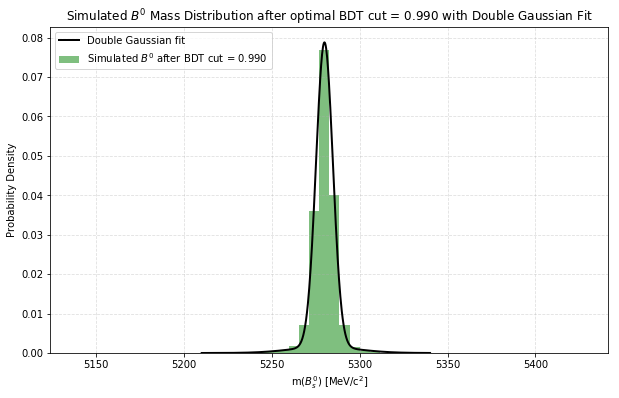

In [71]:
# plot to see how it looks
plt.figure(figsize=(10,6))

observableB = zfit.Space("mass", limits=(5210, 5340))
mass_valuesB = cut_bzero["B_FitDaughtersConst_M_flat"].values

# plot the cut simulated mass data histogram
plt.hist(mass_valuesB,
         bins=50, 
         histtype="stepfilled", color="green", alpha=0.5, 
         density=True, label="Simulated $B^0$ after BDT cut = 0.990")

# plot the fit model
x_b = np.linspace(5210, 5340, 500)
x_fit_b = zfit.Data.from_numpy(obs=observableB, array=x_b)
pdf_b = zfit.run(sim_model_bzero.pdf(x_fit_b))

plt.plot(
    x_b,
    pdf_b,  
    color="black",
    alpha=1,
    linestyle="-",
    linewidth=2,
    label="Double Gaussian fit"
)

plt.xlabel(r"m($B_{s}^0$) [MeV/c$^2$]")
plt.ylabel("Probability Density")
plt.title(r"Simulated $B^0$ Mass Distribution after optimal BDT cut = 0.990 with Double Gaussian Fit")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

You have set up an awesome classifier but it may not be able to catch all combinatorial background in the data sample. Therefore, you should also include a background component into your model. A common choice for combinatorial background is a decreasing exponential function.

**Ex 6.4: Fit the full data mass with the fixed peak shapes and an exponential background.**
<h4>
Hint: <a class="anchor-link jp-InternalAnchorLink" href="#Z">
Don't forget to include a scale factor for each component.
</a></h4>

In [72]:
# first we fix the shape parameters from the simulations
mu.floating = False
sigma1.floating = False
sigma2.floating = False
f.floating = False

mu_bzero.floating = False
sigma1_bzero.floating = False
sigma2_bzero.floating = False
f_bzero.floating = False

In [73]:
full_observable = zfit.Space("full_mass", limits=(5200, 5420))
full_mass_data = cut_data["B_FitDaughtersConst_M_flat"].values
full_data = zfit.Data.from_numpy(obs=full_observable, array=full_mass_data)

In [74]:
# define the background component
bkg_model = zfit.Parameter("bkg_sample", -0.001, -1, 0)  # initial guess, then boundaries must be negative

In [75]:
bkg_pdf = zfit.pdf.Exponential(obs=full_observable, lambda_=bkg_model)

# redefine the simulation PDFs for the new observable
full_gauss1 = zfit.pdf.Gauss(obs=full_observable, mu=mu, sigma=sigma1)
full_gauss2 = zfit.pdf.Gauss(obs=full_observable, mu=mu, sigma=sigma2)
full_sim_model = zfit.pdf.SumPDF([full_gauss1, full_gauss2], fracs=[f])

full_gauss1_bzero = zfit.pdf.Gauss(obs=full_observable, mu=mu_bzero, sigma=sigma1_bzero)
full_gauss2_bzero = zfit.pdf.Gauss(obs=full_observable, mu=mu_bzero, sigma=sigma2_bzero)
full_sim_model_bzero = zfit.pdf.SumPDF([full_gauss1_bzero, full_gauss2_bzero], fracs=[f_bzero])

In [76]:
frac_bs = zfit.Parameter("frac_bs", 0.2, 0, 1)
frac_b0 = zfit.Parameter("frac_b0", 0.4, 0, 1)
frac_bkg = 1 - frac_bs - frac_b0

In [77]:
full_model = zfit.pdf.SumPDF([full_sim_model, full_sim_model_bzero, bkg_pdf], fracs=[frac_bs, frac_b0, frac_bkg])

full_nll = zfit.loss.UnbinnedNLL(model=full_model, data=full_data)

full_minimizer = zfit.minimize.Minuit()
full_result = full_minimizer.minimize(full_nll)

full_hesse_errors = full_result.hesse()

print("Fit converged:", full_result.converged)
print("\n Fit paramters with errors: \n")
for param in full_result.params:
    value = full_result.params[param]['value']
    error = full_hesse_errors[param]['error']
    print(f"{param.name}: {value:.3f} ± {error:.3f}")

------------------------------------------------------------------
| FCN = 1.843E+04               |      Ncalls=73 (73 total)      |
| EDM = 8.76E-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------
|   | Name       |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--

**Ex 6.5: Plot the fully fitted model, its 3 submodels and the selected data distribution**

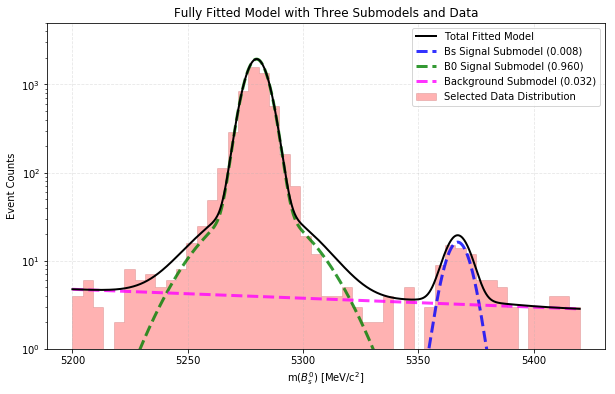

In [78]:
plt.figure(figsize=(10,6))

full_x = np.linspace(5200, 5420, 1000)
full_x_fit = zfit.Data.from_numpy(obs=full_observable, array=full_x)

# the total fitted model PDF
full_pdf = zfit.run(full_model.pdf(full_x_fit))

# fitted fraction values 
frac_bs_val = float(zfit.run(frac_bs))
frac_b0_val = float(zfit.run(frac_b0))
frac_bkg_val = 1 - frac_bs_val - frac_b0_val

# plot the submodels
bs_pdf = zfit.run(full_sim_model.pdf(full_x_fit))
b0_pdf = zfit.run(full_sim_model_bzero.pdf(full_x_fit))
bkg_pdf_ = zfit.run(bkg_pdf.pdf(full_x_fit))

#bin_width = (5420-5200)/50
bins = np.linspace(5200, 5420, 50)
bin_width = bins[1]-bins[0]
scale_factor = len(full_mass_data)*bin_width
full_pdf_scaled = scale_factor*full_pdf

bs_component = scale_factor*bs_pdf*frac_bs_val
b0_component = scale_factor*b0_pdf*frac_b0_val
bkg_component = scale_factor*bkg_pdf_*frac_bkg_val

# plot the data histogram
plt.hist(full_mass_data,
         bins=bins,
         histtype="stepfilled",
         color="red",
         alpha=0.3,
         density=False,
         label="Selected Data Distribution",
         edgecolor='darkred',
         linewidth=0.5,
         log=True
)

# plot the total fitted model
plt.plot(full_x, full_pdf_scaled, 
         color="black", 
         linestyle="-",
         linewidth=2, 
         label="Total Fitted Model", 
         zorder=5)

plt.plot(full_x, bs_component, 
         '--', 
         color='blue', 
         linewidth=3, 
         label=f'Bs Signal Submodel ({frac_bs_val:.3f})', 
         alpha=0.8)

plt.plot(full_x, b0_component, 
         '--', 
         color='green', 
         linewidth=3, 
         label=f'B0 Signal Submodel ({frac_b0_val:.3f})', 
         alpha=0.8)

plt.plot(full_x, bkg_component, 
         '--', 
         color='magenta', 
         linewidth=3, 
         label=f'Background Submodel ({frac_bkg_val:.3f})', 
         alpha=0.8)

plt.xlabel(r"m($B_{s}^0$) [MeV/c$^2$]")
plt.ylabel("Event Counts")
plt.ylim(1, 5000)
plt.title(r"Fully Fitted Model with Three Submodels and Data")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

In [79]:
print(frac_bs_val, frac_b0_val,frac_bkg_val)

0.008489039237001617 0.9595923001603731 0.03191866060262527


Looking good! We see our $B_s$ peak!

Let's evaluate the statistical sigificance of our observation. The correct way of doing this is rather complicated and tedious which is beyond the scope of what we can and want to do here. Instead, we will use
$m = \frac{n_{sig}}{\sqrt{n_{sig}+n_{bkg}}}$
as a simple proxy for the statistical significance. The numbers $n_i$ are the number of signal/background events in the signal region.

**Ex 6.6: Calculate $n_{sig}$, $n_{bkg}$, and the significance proxy $m$!**

In [80]:
total_events = len(full_mass_data)

n_total = len(full_mass_data)
n_sig = frac_bs_val*n_total
n_bkg = frac_bkg_val*n_total
m = n_sig/np.sqrt(n_sig+n_bkg)

print(f"n_sig = {n_sig:.2f}")
print(f"n_bkg = {n_bkg:.2f}")
print(f"Significance proxy m = {m:.2f}")

n_sig = 48.49
n_bkg = 182.32
Significance proxy m = 3.19


**Congratulations! You did it. Now you are more than ready for a thesis at E5 :)**